# Akbank Deep Learning-Bootcamp
Merhabalar bu notebookumda akbank derin öğrenme bootcampinde car-brand-classification datasetini kullanarak oluşturduğum projemi inceleyeceğiz.
Bu notebookta:
* Elimizdeki verilerin overfit ya da underfit olmaması adına data augmentation uygulayacağız.
* Verisetimizdeki verilerin dağılımını python kütüphaneleri kullanarak görselleştireceğiz.
* CNN tabanlı bir mimari oluşturacağız.
* Modelimizin sonuçlarını grafiklerle göstereceğiz.

Temel kütüphanelerimizi **import** ediyoruz ve verisetimizdeki klasörleri kontrol ederek bir değişkene atıyoruz.

In [1]:
import os, sys, random
from pathlib import Path
from glob import glob
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
DATA_DIR = Path("/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset")
assert (DATA_DIR / "train").exists()

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"   
TEST_DIR  = DATA_DIR / "test" 

Split: train
  Sınıf sayısı: 33
  Toplam görsel: 11517
  Açılamayan: 0
----------------------------------------


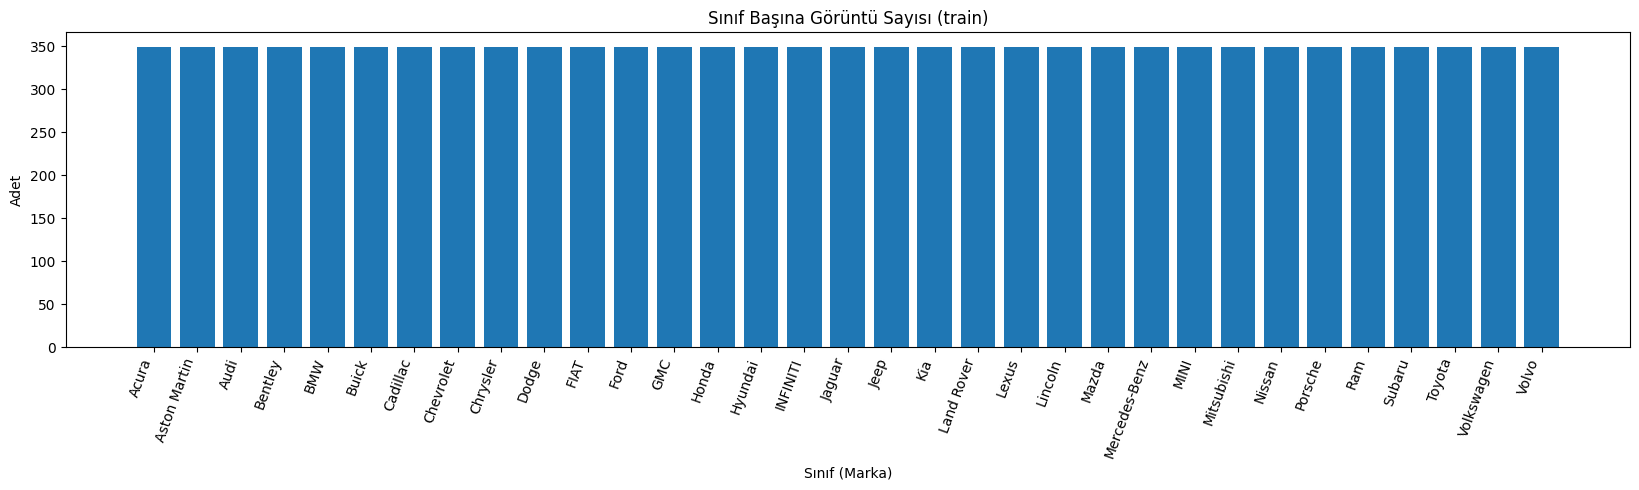

Split: val
  Sınıf sayısı: 33
  Toplam görsel: 2475
  Açılamayan: 0
----------------------------------------


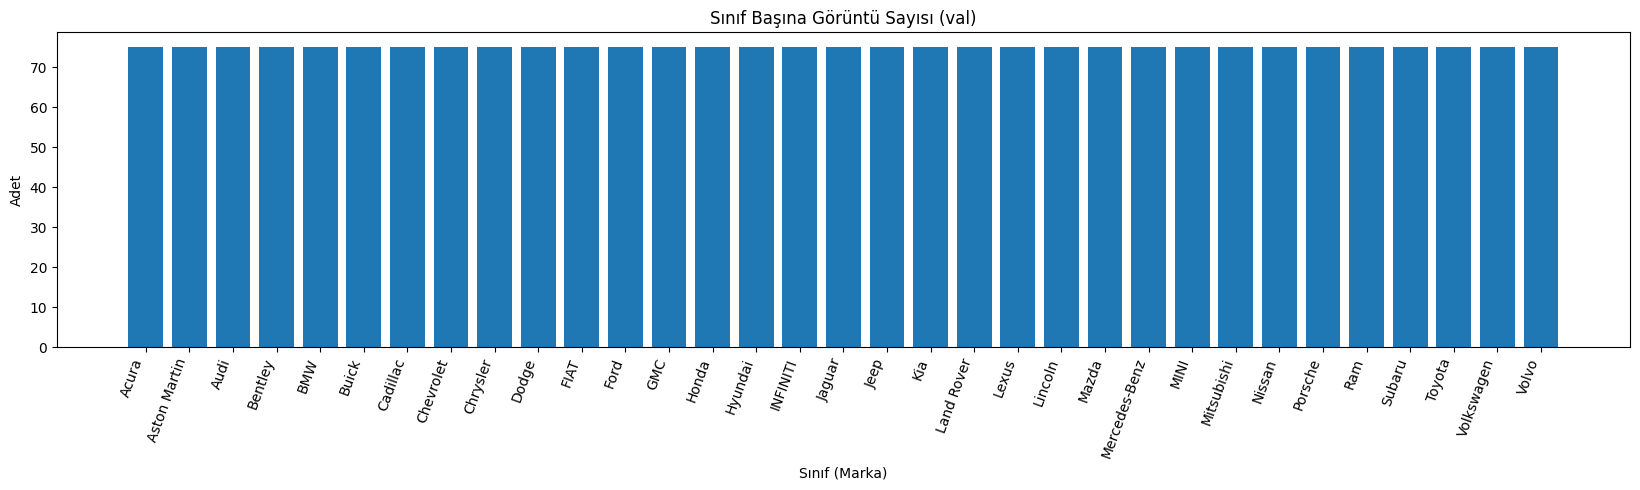

Split: test
  Sınıf sayısı: 33
  Toplam görsel: 2475
  Açılamayan: 0
----------------------------------------


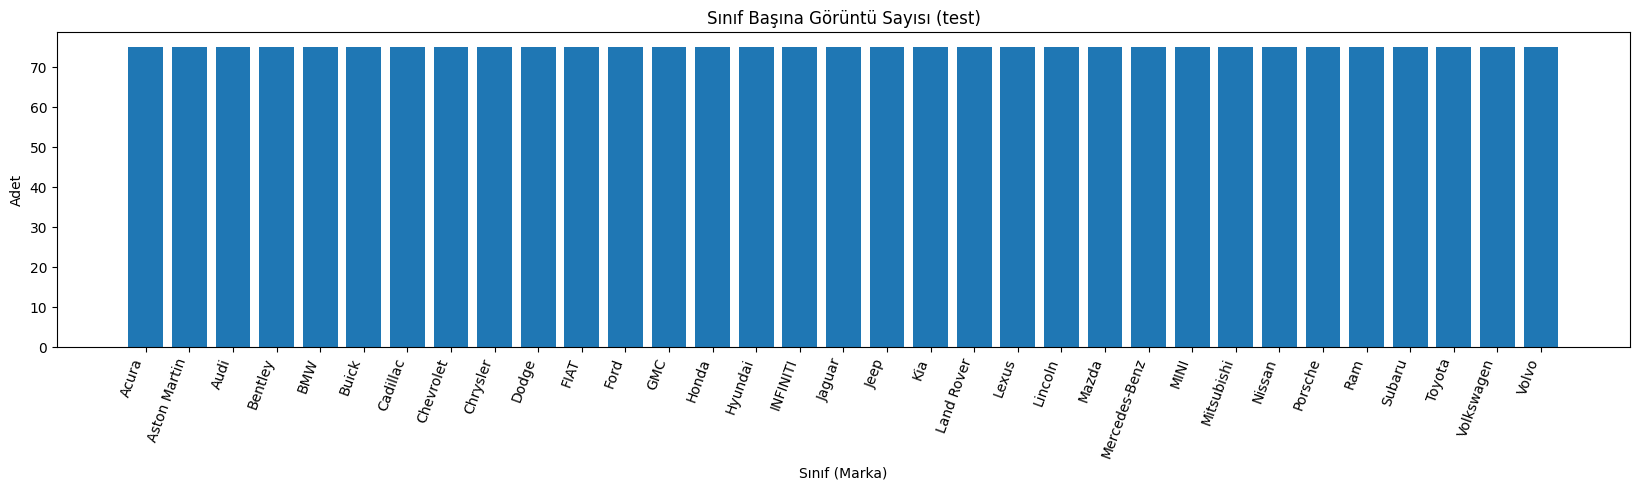

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Ana dataset dizini
DATA_DIR = Path("/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset")
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp",".tiff",".jfif"}

def analyze_split(split):
    SPLIT_DIR = DATA_DIR / split
    assert SPLIT_DIR.exists(), f"{SPLIT_DIR} bulunamadı."
    
    records, bad = [], 0
    class_dirs = sorted([d for d in SPLIT_DIR.iterdir() if d.is_dir()], key=lambda x: x.name.lower())
    
    for cls_dir in class_dirs:
        cls = cls_dir.name
        for p in cls_dir.iterdir():
            if p.is_file() and p.suffix.lower() in IMG_EXTS:
                try:
                    with Image.open(p) as im:
                        w, h = im.size
                except Exception:
                    w, h = None, None
                    bad += 1
                records.append({"path": str(p), "class": cls, "width": w, "height": h})
    
    df = pd.DataFrame(records)
    assert len(df), f"{split} içinde uygun görsel bulunamadı."
    
    df_counts = (df["class"].value_counts()
                 .sort_values(ascending=False)
                 .rename_axis("class")
                 .reset_index(name="count"))
    
    num_classes = len(df_counts)
    total_images = df_counts["count"].sum()
    
    print(f"Split: {split}")
    print(f"  Sınıf sayısı: {num_classes}")
    print(f"  Toplam görsel: {total_images}")
    print(f"  Açılamayan: {bad}")
    print("-"*40)
    
    return df_counts, num_classes, total_images, bad

# Train, Val, Test analiz
results = {}
for split in ["train", "val", "test"]:
    df_counts, num_classes, total_images, bad = analyze_split(split)
    results[split] = df_counts
    
    # Görselleştirme
    plt.figure(figsize=(max(12, num_classes*0.5), 5))
    plt.bar(df_counts["class"], df_counts["count"])
    plt.title(f"Sınıf Başına Görüntü Sayısı ({split})")
    plt.xlabel("Sınıf (Marka)")
    plt.ylabel("Adet")
    plt.xticks(rotation=70, ha="right")
    plt.tight_layout()
    plt.show()


Burada split değerine 3 farklı klasörümüzü vererek bir döngü içerisinde tek tek train val ve test klasörlerimizin veri dağılımlarını kontrol ediyoruz.Oranlara bakarsak yaklaşık %70,%15,%15 yani kabul edilir bir dağılımımız var.**Peki bu dağılımların önemi ne?** Eğer eksik bir class olursa ya da verilerde doğru bir oran olmazsa bu sonucumuzun sapmasına yol açar.

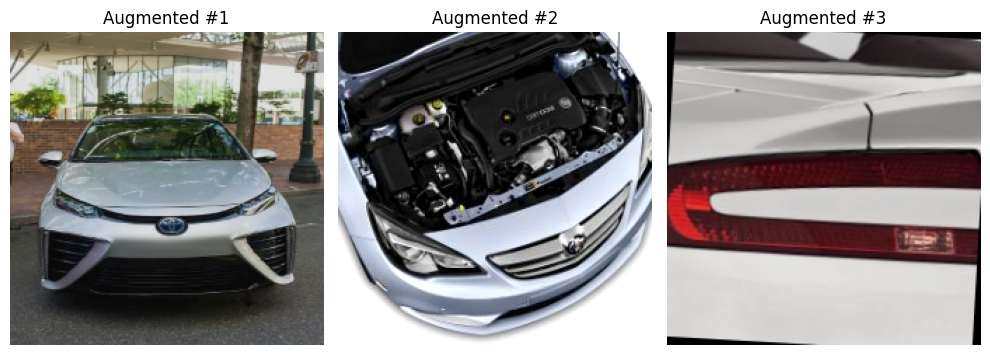

In [7]:
#Albumentations ile data augmentation(veri çoğaltımı)

import random, math
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ==== Ayarlar ====
DATA_DIR = Path("/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset")
TRAIN_DIR = DATA_DIR / "train"
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp",".tiff",".jfif"}
IMG_SIZE = 224
SEED = 42
random.seed(SEED)

# ==== Sadece TRAIN için augmentation ====
mean_rgb = [0.485, 0.456, 0.406]
std_rgb  = [0.229, 0.224, 0.225]

def RRC(size, **kwargs):
    try:
        return A.RandomResizedCrop(size=(size, size), **kwargs)
    except TypeError:
        return A.RandomResizedCrop(height=size, width=size, **kwargs)

train_aug = A.Compose([
    RRC(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=8, p=0.6),
    A.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.12, hue=0.02, p=0.7),
    A.Normalize(mean=mean_rgb, std=std_rgb),
    ToTensorV2(),
])

# ==== Basit ImageFolder (Albumentations'lı) ====
class AlbumentationsImageFolder(Dataset):
    def __init__(self, root_dir: Path, transform):
        self.root = Path(root_dir)
        self.transform = transform
        self.samples = []
        for cls_dir in sorted([d for d in self.root.iterdir() if d.is_dir()], key=lambda p: p.name.lower()):
            for p in cls_dir.iterdir():
                if p.is_file() and p.suffix.lower() in IMG_EXTS:
                    self.samples.append(str(p))
        if not self.samples:
            raise RuntimeError(f"{root_dir} içinde uygun görsel bulunamadı.")

    def __len__(self): 
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        with Image.open(path) as im:
            img = np.asarray(im.convert("RGB"))
        out = self.transform(image=img)["image"]   # CxHxW tensor (normalized)
        return out

# ==== Dataset oluştur, 2 örnek görselleştir ====
train_ds = AlbumentationsImageFolder(TRAIN_DIR, train_aug)

# 3 farklı rasgele indeks seç
idxs = random.sample(range(len(train_ds)), 3)
x1, x2, x3 = [train_ds[i] for i in idxs]   # normalized tensorlar (C,H,W) (channel height width pytorch formatı)

# Görselleştirme için unnormalize
m = torch.tensor(mean_rgb).view(3,1,1)
s = torch.tensor(std_rgb).view(3,1,1)

def unnorm(x):
    return torch.clamp(x*s + m, 0, 1).permute(1,2,0).cpu().numpy()

imgs = [unnorm(x1), unnorm(x2), unnorm(x3)]

plt.figure(figsize=(10,4))
for i, im in enumerate(imgs, 1):
    plt.subplot(1,3,i)
    plt.imshow(im)
    plt.title(f"Augmented #{i}")
    plt.axis("off")
plt.tight_layout(); plt.show()



Bu kısımda amacım **albumentations** kütüphanesini kullanarak yaptığım veri çoğaltımının örneğini görebilmekti.Veri çoğaltmayı ilk olarak **randomresizedcrop** yaparak başlatıyoruz bu görüntümüzün random yani rastgele bir kısmını kırpmaya veya resizelamaya yarıyor.Train augmentation kısmında bunların oranını ayarlıyoruz.Verilerimizi pytorchun anlayabileceği formata çevirmek için **AlbumentationsImageFolder** classımız var bu classta klasördeki her bir sınıfı index biçimine çeviriyoruz daha sonra da içerisindeki verileri augmentation uygulanması için sample kısmına kaydediyoruz.Modelimize Augmentation uyguladığımız verileri verebilmek adına (image,label) formatında döndürüyoruz(Buradaki amacım göstermek olduğu için model eğitimi için olan kısımda birlikte çalıştırmak için tekrar kullanıcam).

Başlamadan önce **CNN(Convolutional Neural Network)**,modelimizin katmanları ve kullanacağım fonksiyonlardan bahsetmek istiyorum.CNN'ler görsel verilerden özellik çıkarımı yapmamızı sağlayan yapay sinir ağıdır.Cnnler ilk olarak küçük parçaları tanımlar daha sonra karmaşık(soyut) kısımlarını tanımlar.Pooling layerı aslında süzgeç gibi düşünebiliriz özellik haritalarımızı küçültür ve gereksiz bilgiyi atar.Dropout eğitim sırasında bazı nöronları rastgele kapatarak (örneğin %50’sini) aşırı öğrenmeyi (overfitting) engeller.Dense layerımız ise **Convolution ve Pooling** katmanlarından çıkan **öznitelikleri** (features) kullanarak son sınıflandırmayı yapar.Aktivasyon fonksiyonlarımız modele doğrusal olmayan karar verme gücü sağlamamıza yarar örnek olarak en çok kullanılan **Relu ve softmax** verilebilir.

Bu kod bloğu çalışan bir blok halinde bütün olarak var olduğundan dolayı üstte ve altta olmak üzere iki anlatım yapacağım.Kodun üst bölümünü burada açıklayacağım.
Önceki blokta zaten augmentationı örnekleri ile birlikte göstermiştim.Bu kodda ek olarak test ve valid klasörlerimde de normalizasyon uyguladım ayrıca dataloaderlar kullandım
AlbumentationsImageFolder classımdan mini batchler üreterek veriyi doğru sırada besleyen taşıyıcı olarak düşünülebilir.
Model kısmına gelirsek:

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.feat = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128),
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.cls  = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.feat(x); x = self.pool(x); x = self.cls(x); return x
if USE_TL:#transfer learning kullanımı senaryosunda burası devreye giriyor
    import torchvision.models as tvm
    model = tvm.resnet18(weights=tvm.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    for name, p in model.named_parameters():
        if not name.startswith("fc"):
            p.requires_grad = False
    params = [p for p in model.parameters() if p.requires_grad]
else:
    model = SimpleCNN(NUM_CLASSES)
    params = model.parameters()

model = model.to(DEVICE)

Bu bir simple cnn örneği nnmoduleden türemesi benim bazı fonksiyonları kullanmama olanak sağlıyor.Modelde **conv_blok** adlı bir fonksiyon ekledim bu fonksiyon sayesinde bir katman yapısı eklemek istediğimde bu fonksiyona eklemem yeterli oluyor.Bu blok şu kısımlardan oluşuyor:RGB resim (3 kanal)dan sonra 32 kanal feature map üretilir.ReLU uygulanır(Bunu açıklamıştım üst markdownlardan birinde).Aynı 32 kanal tekrar konvolüsyondan geçer ve daha derin özellikler çıkar.Tekrar ReLUdan geçer.MaxPoolingde ise boyut yarıya iner.Alt kısımda ise transfer learning durumunda hazır eğitilmiş katmanlar yani **Resnet** katmanları kullanılıyor sadece son katman eğitiliyor.Kullanılmama durumunda ise cnn modelim kullanılıyor.

Deneme yaparken rahat olması adına bazı flagler mevcut bunlar:USE_TENSORBOARD, USE_EARLY_STOP, USE_CLASS_WEIGHTS, USE_WEIGHTED_SAMPLER, RUN_GRADCAM_DEMO, RUN_HP_SEARCH.Bunları açıp kapayarak neler olduğunu daha rahat görebiliyorum.

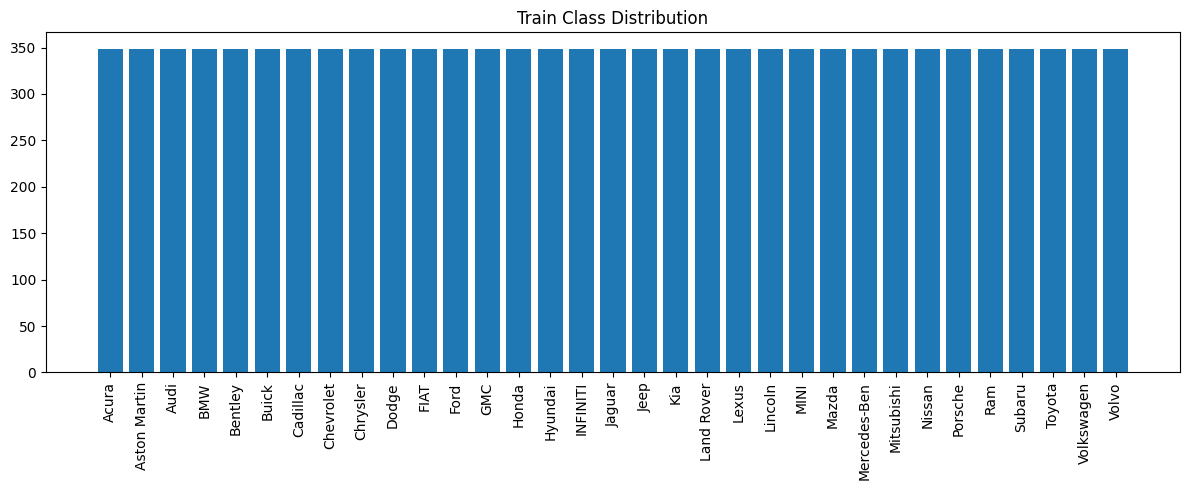

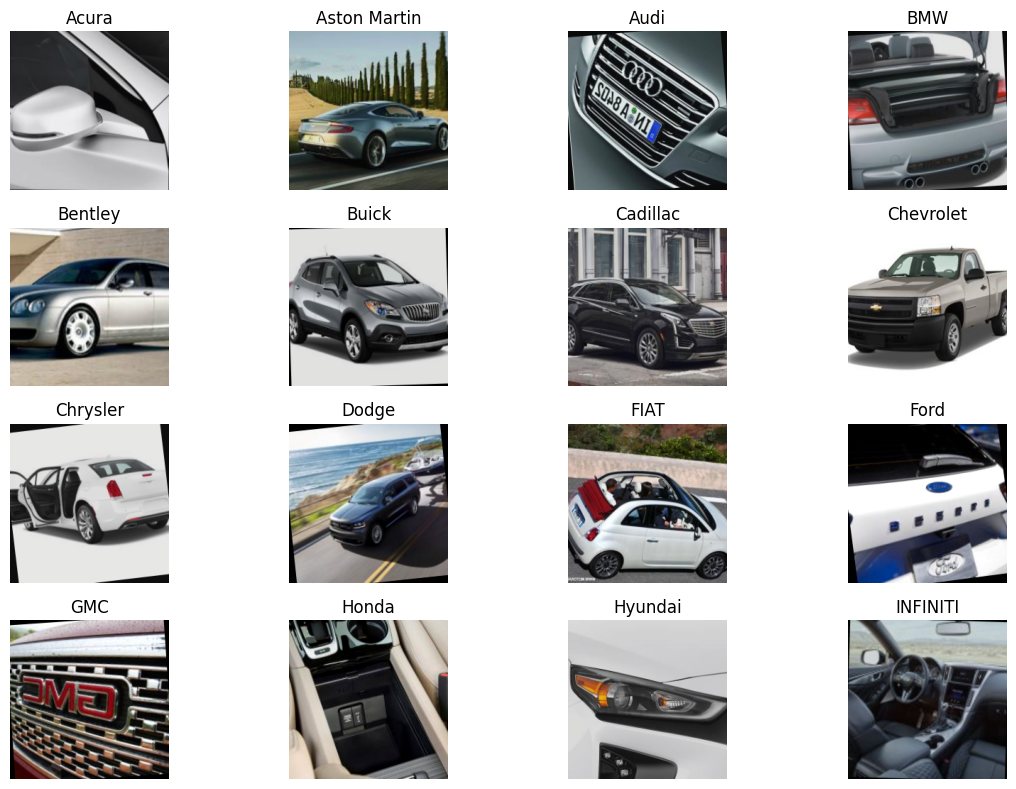

Epoch 01 | LR 1.00e-03 | Train 3.3277/0.101 | Val 3.1449/0.154
Epoch 02 | LR 1.00e-03 | Train 2.9841/0.187 | Val 2.9947/0.189
Epoch 03 | LR 1.00e-03 | Train 2.8292/0.228 | Val 2.9676/0.200
Epoch 04 | LR 1.00e-03 | Train 2.7407/0.253 | Val 2.9293/0.203
Epoch 05 | LR 1.00e-03 | Train 2.6843/0.270 | Val 2.9009/0.230
Epoch 06 | LR 1.00e-03 | Train 2.6250/0.282 | Val 2.9402/0.212
Epoch 07 | LR 1.00e-03 | Train 2.5963/0.289 | Val 2.9289/0.233
Epoch 08 | LR 1.00e-03 | Train 2.5548/0.300 | Val 2.8816/0.232
Epoch 09 | LR 1.00e-03 | Train 2.5374/0.304 | Val 2.8951/0.232
Epoch 10 | LR 1.00e-03 | Train 2.4952/0.313 | Val 2.8972/0.237
Epoch 11 | LR 5.00e-04 | Train 2.4930/0.313 | Val 2.9097/0.220
Epoch 12 | LR 5.00e-04 | Train 2.4076/0.336 | Val 2.8799/0.235
Epoch 13 | LR 5.00e-04 | Train 2.3885/0.344 | Val 2.8634/0.239
Epoch 14 | LR 5.00e-04 | Train 2.3911/0.339 | Val 2.8624/0.247
Epoch 15 | LR 5.00e-04 | Train 2.3680/0.347 | Val 2.8801/0.238

Toplam eğitim süresi: 8.0 dk
En iyi model kaydedildi: 

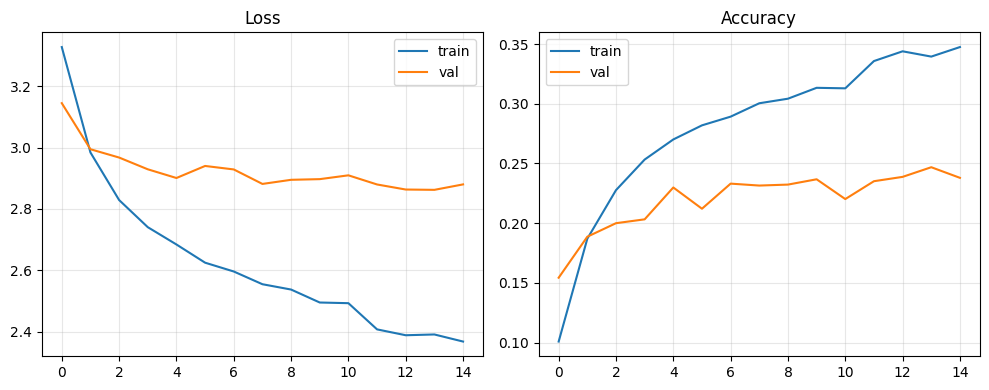


Classification Report (Test):

               precision    recall  f1-score   support

        Acura     0.2400    0.1600    0.1920        75
 Aston Martin     0.2704    0.5733    0.3675        75
         Audi     0.1902    0.4667    0.2703        75
          BMW     0.1071    0.3200    0.1605        75
      Bentley     0.2958    0.2800    0.2877        75
        Buick     0.1500    0.2000    0.1714        75
     Cadillac     0.2404    0.3333    0.2793        75
    Chevrolet     0.2105    0.0533    0.0851        75
     Chrysler     0.4894    0.3067    0.3770        75
        Dodge     0.3191    0.2000    0.2459        75
         FIAT     0.5667    0.2267    0.3238        75
         Ford     0.0606    0.0267    0.0370        75
          GMC     0.3535    0.4667    0.4023        75
        Honda     0.2034    0.1600    0.1791        75
      Hyundai     0.1728    0.1867    0.1795        75
     INFINITI     0.3000    0.3200    0.3097        75
       Jaguar     0.1538    0.05

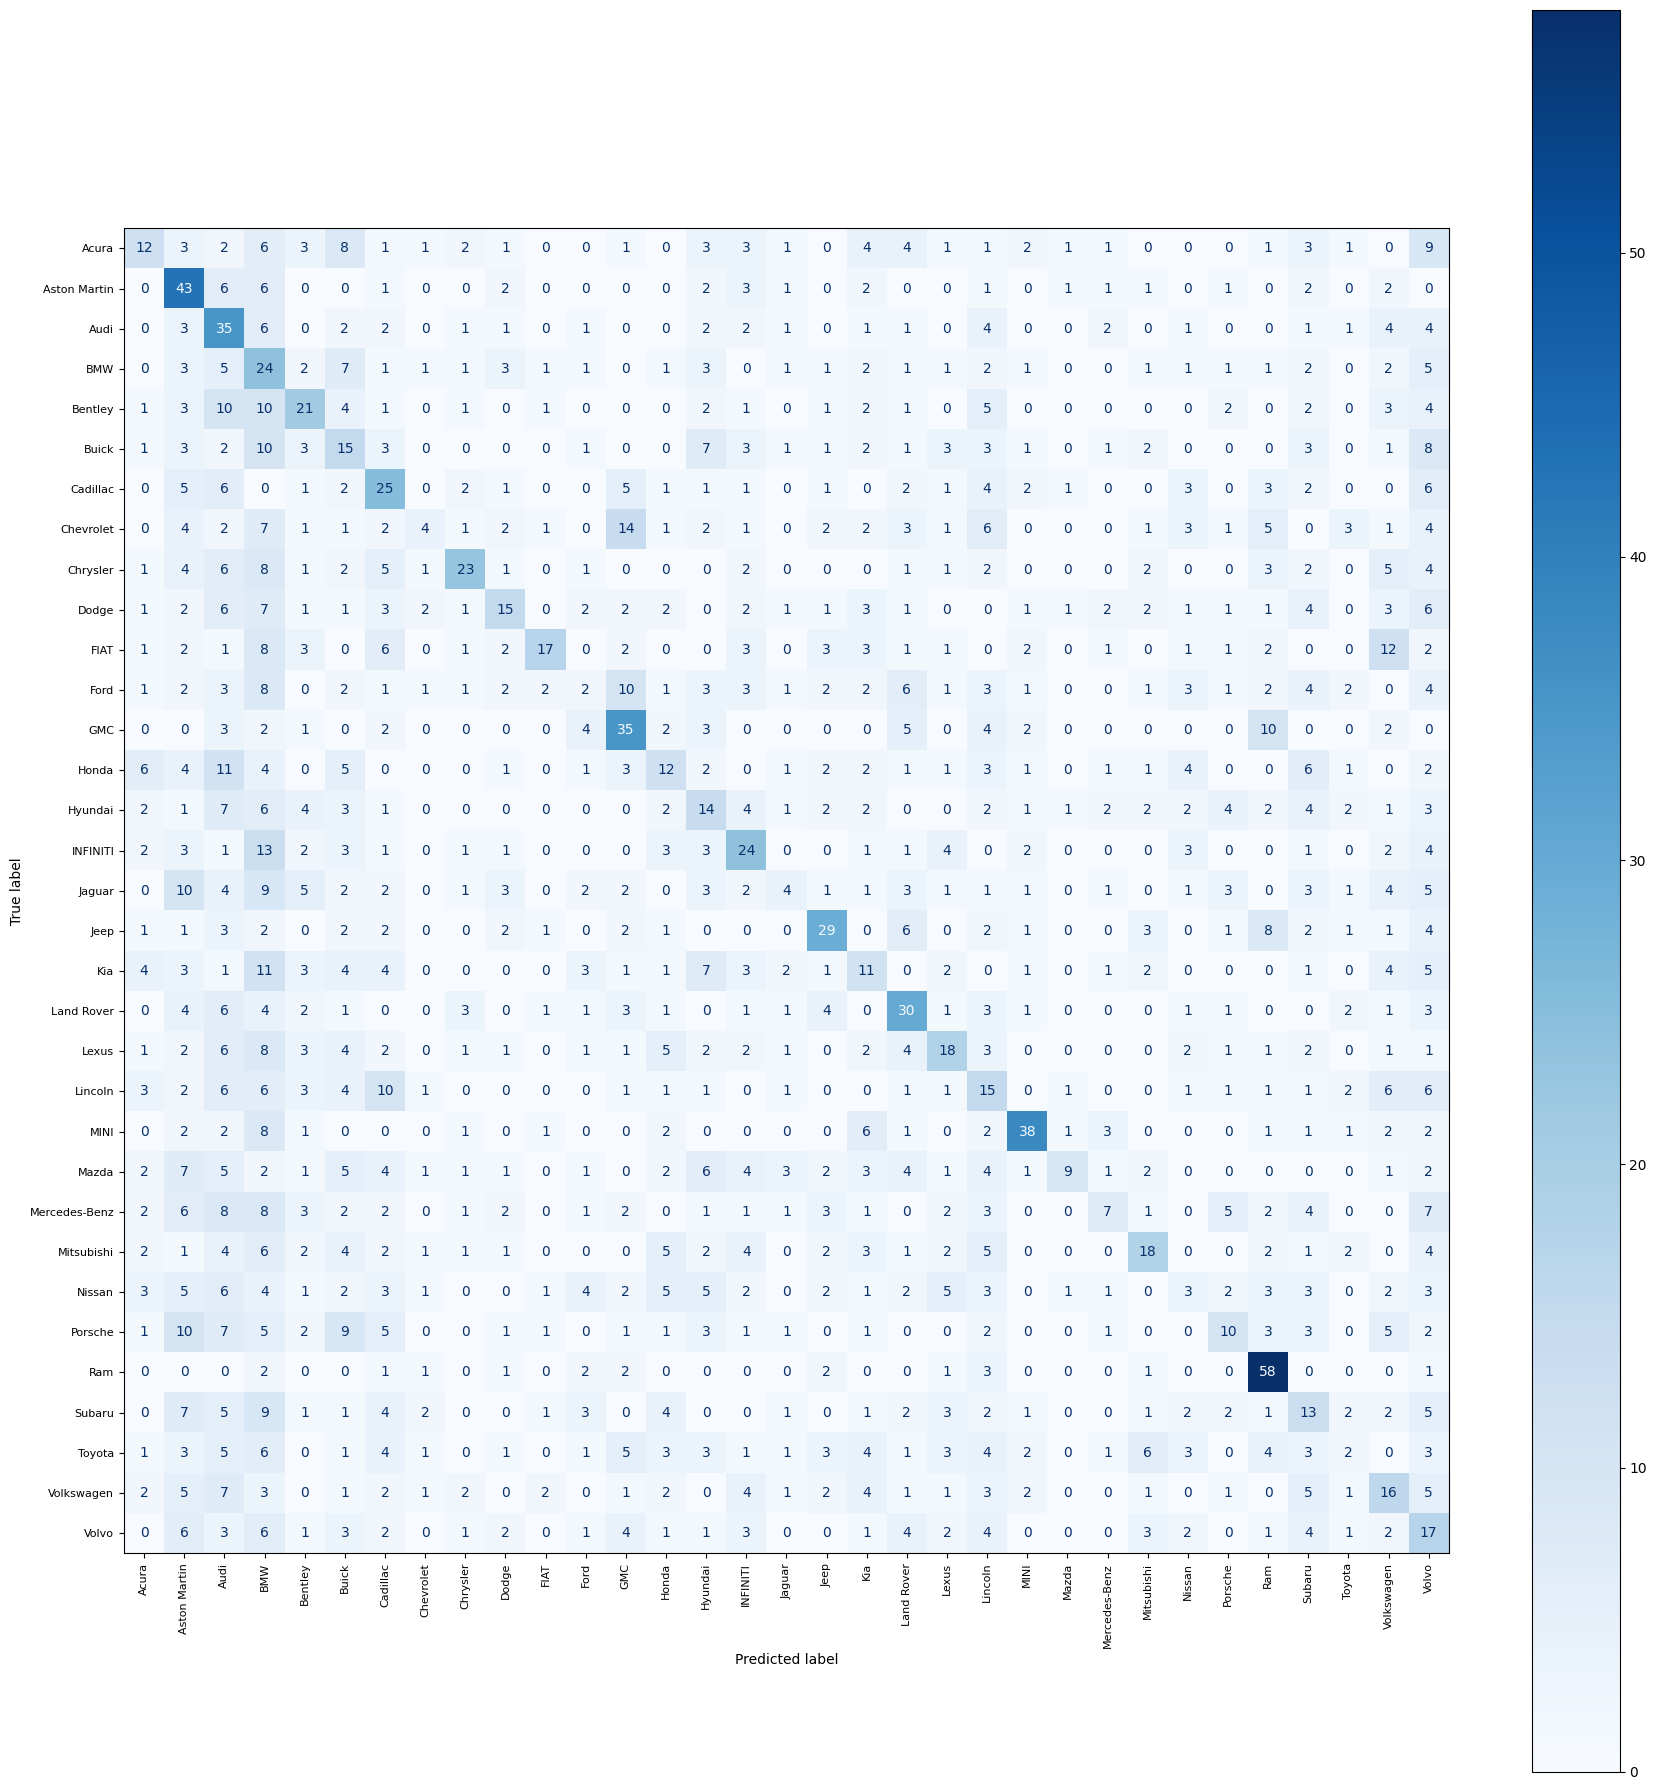

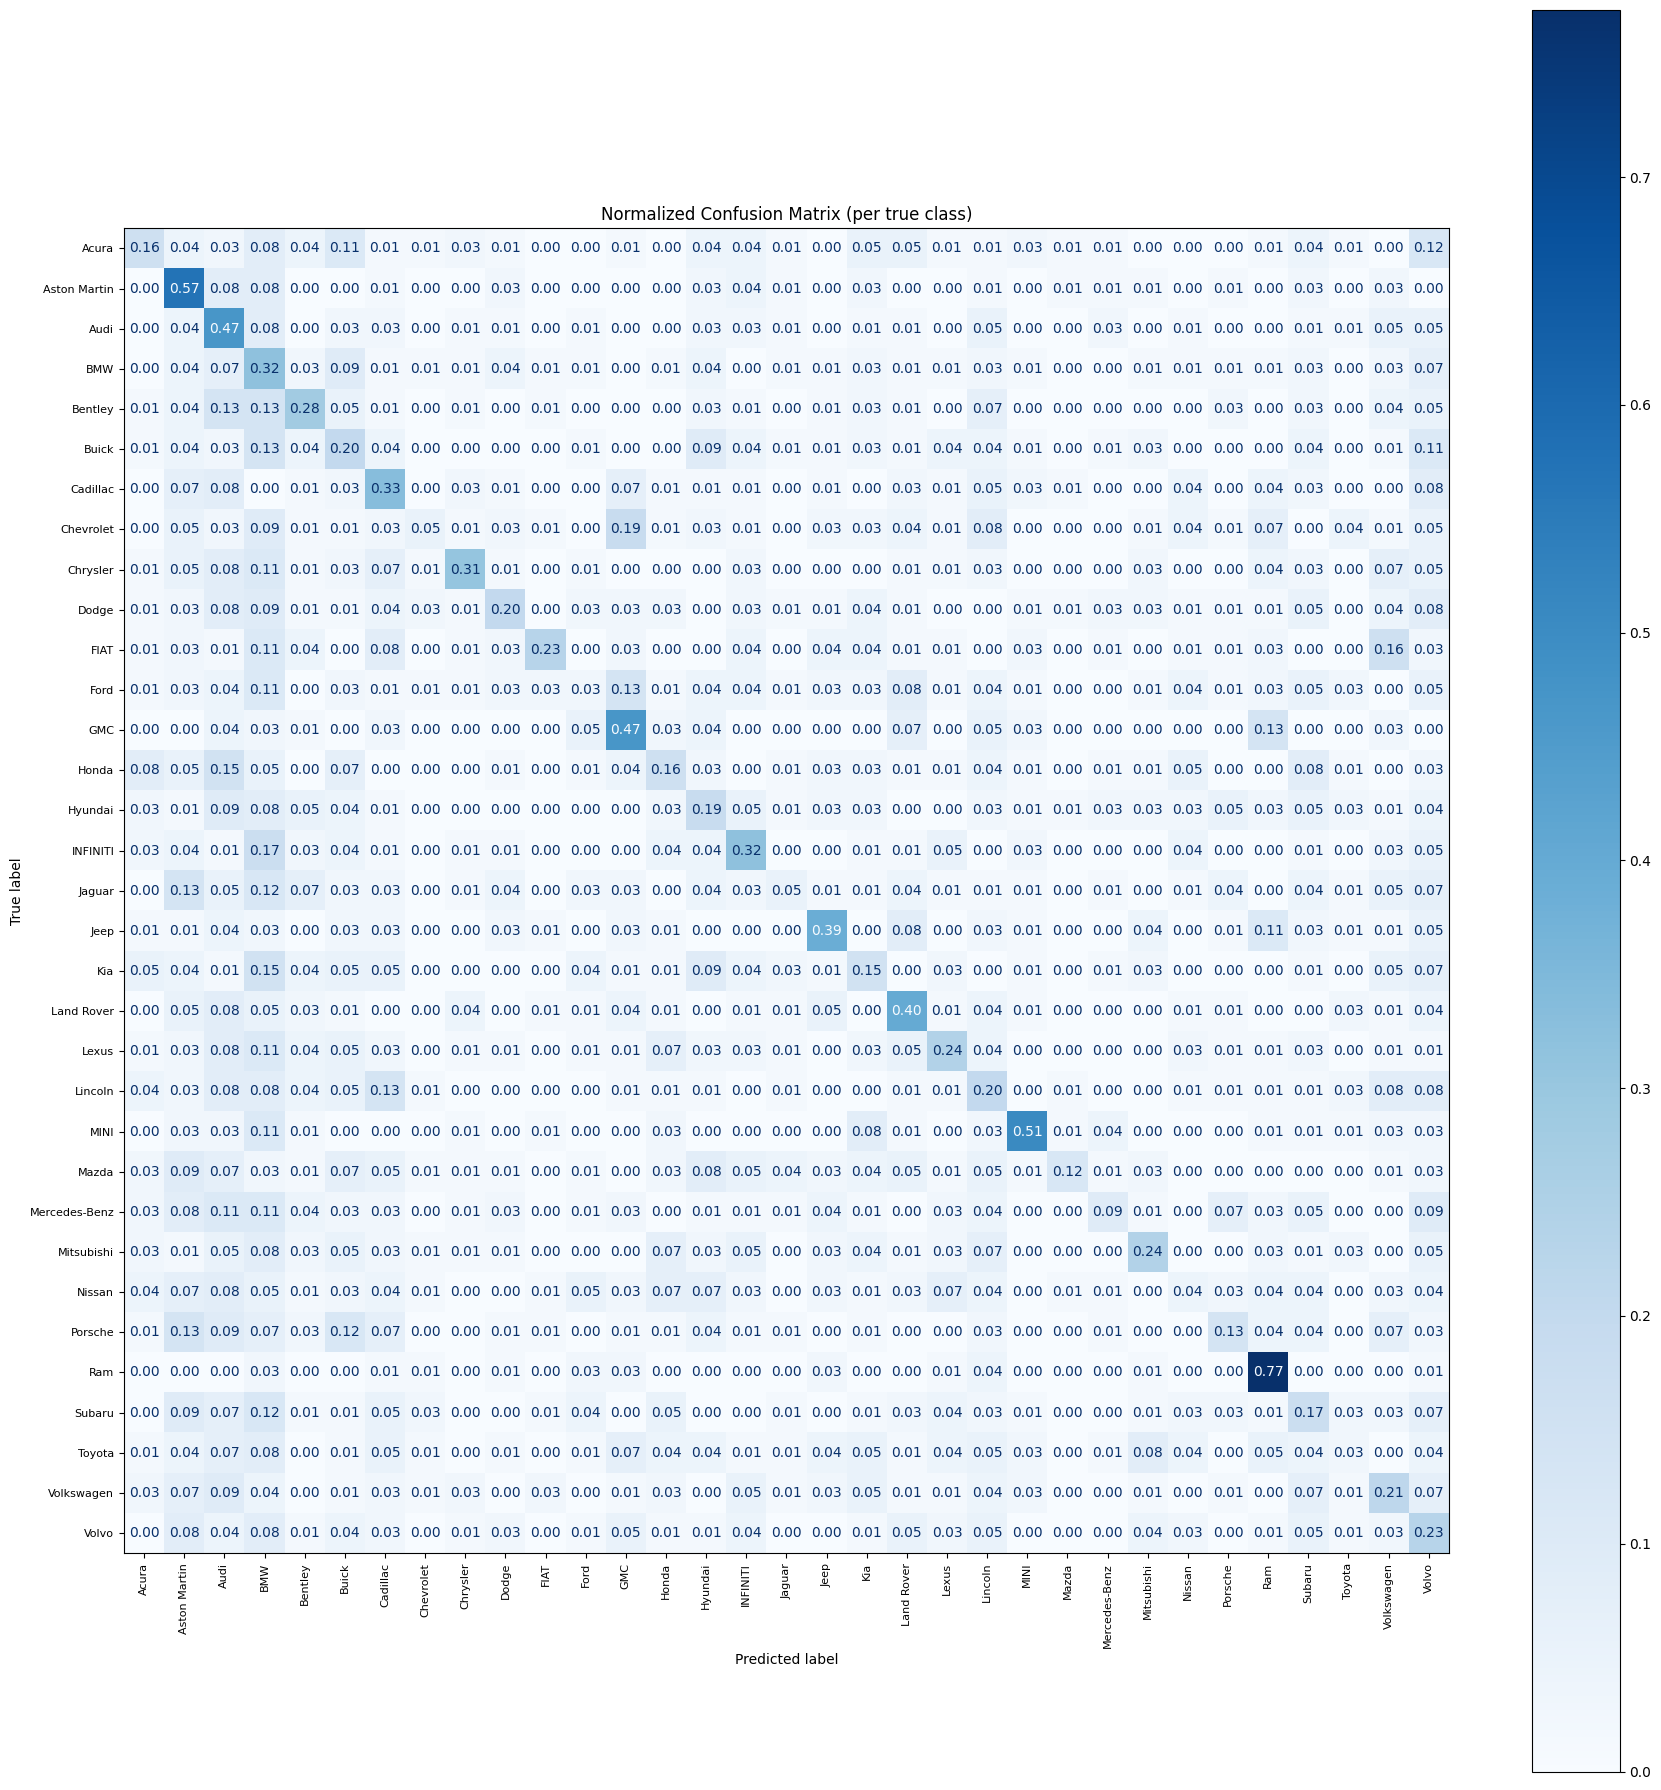

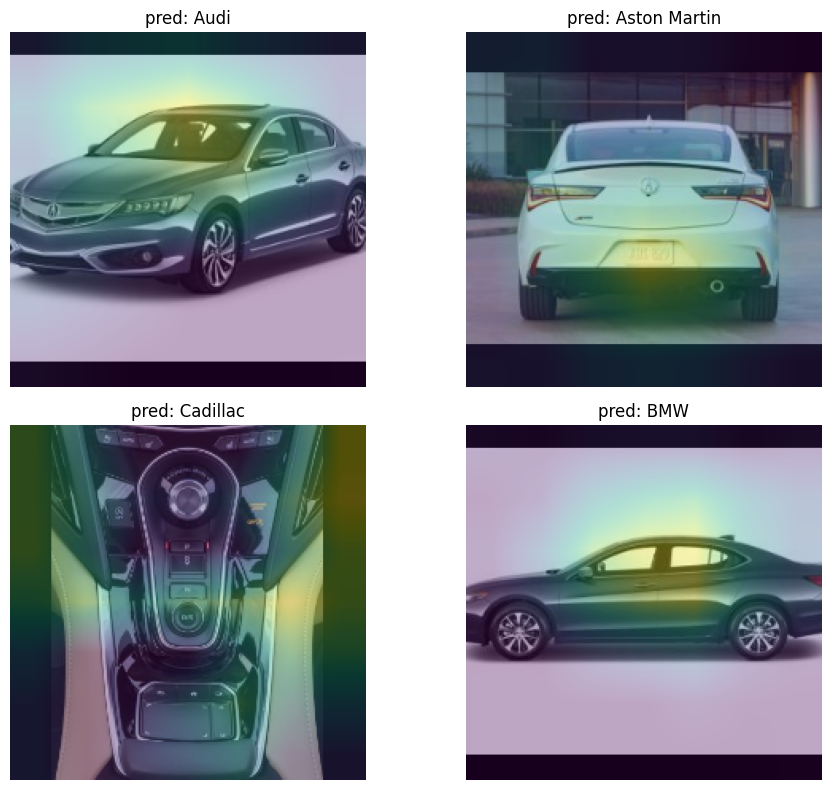

In [3]:

import numpy as np, torch, cv2, math, random, os
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
from pathlib import Path
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
ImageFile.LOAD_TRUNCATED_IMAGES = True

USE_TENSORBOARD = True         # izleme kısmı 
USE_EARLY_STOP  = True         # early stopping
USE_CLASS_WEIGHTS = False      # CrossEntropyLoss'ı class-weight ile kur
USE_WEIGHTED_SAMPLER = False   # train loader için WeightedRandomSampler
RUN_GRADCAM_DEMO = True        # eğitimden sonra birkaç görüntüde Grad-CAM
RUN_HP_SEARCH = False          # mini hiperparametre taraması fonksiyonunu çalıştır

DATA_DIR = Path("/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset")
TRAIN_DIR, VAL_DIR, TEST_DIR = DATA_DIR/"train", DATA_DIR/"val", DATA_DIR/"test"
IMG_SIZE, BATCH_SIZE, NUM_WORKERS, SEED = 224, 32, 2, 42
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp",".tiff",".jfif",".gif"}

try:
    mean_rgb, std_rgb = mean_rgb.tolist(), std_rgb.tolist()
except Exception:
    mean_rgb = [0.485, 0.456, 0.406]
    std_rgb  = [0.229, 0.224, 0.225]

def RRC(size, **kwargs):
    try:
        return A.RandomResizedCrop(size=(size, size), **kwargs)
    except TypeError:
        return A.RandomResizedCrop(height=size, width=size, **kwargs)

train_aug = A.Compose([
    RRC(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=8, p=0.6),
    A.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.12, hue=0.02, p=0.7),
    A.Normalize(mean=mean_rgb, std=std_rgb),
    ToTensorV2(),
])

valid_aug = A.Compose([
    A.LongestMaxSize(max_size=int(IMG_SIZE*1.15)),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=mean_rgb, std=std_rgb),
    ToTensorV2(),
])

class AlbumentationsImageFolder(Dataset):
    def __init__(self, root_dir: Path, transform):
        self.root = Path(root_dir)
        self.transform = transform
        self.samples, self.class_to_idx = [], {}
        classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        for c in classes:
            for p in (self.root / c).rglob("*"):
                if p.is_file() and p.suffix.lower() in IMG_EXTS:
                    self.samples.append((str(p), self.class_to_idx[c]))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        with Image.open(path) as im:
            img = np.asarray(im.convert("RGB"))
        img = self.transform(image=img)["image"]
        return img, label

torch.manual_seed(SEED)
if VAL_DIR.exists():
    train_base = AlbumentationsImageFolder(TRAIN_DIR, train_aug)
    val_base   = AlbumentationsImageFolder(VAL_DIR,   valid_aug)
    train_ds, val_ds = train_base, val_base
else:
    
    full_index_ds = AlbumentationsImageFolder(TRAIN_DIR, transform=None)  
    gen = torch.Generator().manual_seed(SEED)
    val_len  = max(1, int(0.15 * len(full_index_ds)))
    train_len = len(full_index_ds) - val_len
    perm = torch.randperm(len(full_index_ds), generator=gen)
    train_idx, val_idx = perm[:train_len], perm[train_len:]

    train_base = AlbumentationsImageFolder(TRAIN_DIR, transform=train_aug)
    val_base   = AlbumentationsImageFolder(TRAIN_DIR, transform=valid_aug)
    train_ds = Subset(train_base, train_idx.tolist())
    val_ds   = Subset(val_base,   val_idx.tolist())


base_ds = train_ds.dataset if hasattr(train_ds, "dataset") else train_ds
idx_to_class = {v:k for k,v in base_ds.class_to_idx.items()}
class_to_idx = base_ds.class_to_idx
NUM_CLASSES = len(idx_to_class)

from collections import Counter
def class_counts(ds):
    if isinstance(ds, Subset):
        base, idxs = ds.dataset, ds.indices
        labels = [ base[i][1] for i in idxs ]
    else:
        labels = [ ds[i][1] for i in range(len(ds)) ]
    cnt = Counter(int(y) for y in labels)
    names = [idx_to_class[i] for i in range(NUM_CLASSES)]
    vals = [cnt.get(i,0) for i in range(NUM_CLASSES)]
    return names, vals

names, vals = class_counts(train_ds)
plt.figure(figsize=(12,5))
plt.bar(range(len(names)), vals)
plt.xticks(range(len(names)), [n[:12] for n in names], rotation=90)
plt.title("Train Class Distribution"); plt.tight_layout(); plt.show()

# ---- Class imbalance opsiyonları ----
train_sampler = None
if USE_WEIGHTED_SAMPLER:
    counts = np.array(vals, dtype=np.float32)
    counts[counts==0] = 1.0
    inv = 1.0 / counts
    if isinstance(train_ds, Subset):
        weights = [inv[train_ds.dataset[i][1]] for i in train_ds.indices]
    else:
        weights = [inv[train_ds[i][1]] for i in range(len(train_ds))]
    train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

# ---- DataLoader'lar ----
test_ds = AlbumentationsImageFolder(TEST_DIR, valid_aug) if TEST_DIR.exists() else None
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=(train_sampler is None),
                          sampler=train_sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True) if test_ds else None

# ---- Sınıf-dengeli augment grid (tek sınıfa abanmayı önler) ----
def balanced_grid_sample(ds, per_class=1, max_total=16):
    if isinstance(ds, Subset):
        base, idxs = ds.dataset, ds.indices
        pool = [(i, base[i][1]) for i in idxs]
    else:
        pool = [(i, ds[i][1]) for i in range(len(ds))]
    by_class = {}
    for i, y in pool:
        by_class.setdefault(int(y), []).append(i)
    chosen = []
    for c in range(NUM_CLASSES):
        if c in by_class:
            random.shuffle(by_class[c])
            chosen += by_class[c][:per_class]
        if len(chosen) >= max_total: break
    return chosen[:max_total]

sel = balanced_grid_sample(train_ds, per_class=1, max_total=16)
imgs, labels = [], []
for i in sel:
    x, y = (train_ds.dataset[i] if isinstance(train_ds, Subset) else train_ds[i])
    imgs.append(x); labels.append(y)
imgs = torch.stack(imgs); labels = torch.tensor(labels)
m = torch.tensor(mean_rgb).view(1,3,1,1)
s = torch.tensor(std_rgb).view(1,3,1,1)
x = torch.clamp(imgs*s + m, 0, 1)
plt.figure(figsize=(12,8))
for i in range(len(sel)):
    plt.subplot(4,4,i+1)
    plt.imshow(x[i].permute(1,2,0).cpu().numpy())
    plt.title(idx_to_class[int(labels[i])][:18])
    plt.axis("off")
plt.tight_layout(); plt.show()

import time, torch.nn as nn, torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.amp import GradScaler, autocast

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 15
LR = 1e-3
USE_TL = True
SAVE_PATH = "best_model.pt"

# ---- Model ----
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.feat = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128),
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.cls  = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.feat(x); x = self.pool(x); x = self.cls(x); return x

if USE_TL:
    import torchvision.models as tvm
    model = tvm.resnet18(weights=tvm.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    for name, p in model.named_parameters():
        if not name.startswith("fc"):
            p.requires_grad = False
    params = [p for p in model.parameters() if p.requires_grad]
else:
    model = SimpleCNN(NUM_CLASSES)
    params = model.parameters()

model = model.to(DEVICE)

# ---- Class-weighted loss opsiyonu ----
if USE_CLASS_WEIGHTS:
    # train dağılımından ağırlık çıkar
    counts = np.array(vals, dtype=np.float32); counts[counts==0] = 1.0
    class_w = torch.tensor((counts.sum()/counts), dtype=torch.float32, device=DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_w)
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(params, lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

# ---- TensorBoard (opsiyonel) ----
if USE_TENSORBOARD:
    try:
        from torch.utils.tensorboard import SummaryWriter
        writer = SummaryWriter(log_dir="runs/carbrand")
    except Exception as e:
        print("TensorBoard açılamadı:", e)
        USE_TENSORBOARD = False

def run_epoch(loader, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    torch.set_grad_enabled(train)
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = torch.as_tensor(yb, device=DEVICE)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits = model(xb)
            loss = criterion(logits, yb)
        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        loss_sum += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    torch.set_grad_enabled(True)
    return loss_sum/total, correct/total

# ---- Early Stopping ----
best_val = float("inf")
best_epoch = 0
PATIENCE = 5  # istersen değiştir
hist = {"tr_loss":[], "tr_acc":[], "va_loss":[], "va_acc":[]}
t0 = time.time()

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    with torch.no_grad():
        va_loss, va_acc = run_epoch(val_loader, train=False)
    scheduler.step(va_loss)

    hist["tr_loss"].append(tr_loss); hist["tr_acc"].append(tr_acc)
    hist["va_loss"].append(va_loss); hist["va_acc"].append(va_acc)

    if USE_TENSORBOARD:
        writer.add_scalar("Loss/train", tr_loss, epoch)
        writer.add_scalar("Loss/val",   va_loss, epoch)
        writer.add_scalar("Acc/train",  tr_acc,  epoch)
        writer.add_scalar("Acc/val",    va_acc,  epoch)

    cur_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d} | LR {cur_lr:.2e} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")

    if va_loss < best_val:
        best_val = va_loss
        best_epoch = epoch
        torch.save({
            "model": model.state_dict(),
            "num_classes": NUM_CLASSES,
            "idx_to_class": idx_to_class
        }, SAVE_PATH)

    if USE_EARLY_STOP and (epoch - best_epoch) >= PATIENCE:
        print(f"Early stop: {epoch} (best val @ {best_epoch}, loss={best_val:.4f})")
        break

if USE_TENSORBOARD:
    writer.close()

print(f"\nToplam eğitim süresi: {(time.time()-t0)/60:.1f} dk")
print(f"En iyi model kaydedildi: {SAVE_PATH}")

# ---- Eğitim grafikleri ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist["tr_loss"], label="train"); plt.plot(hist["va_loss"], label="val"); plt.title("Loss"); plt.legend(); plt.grid(True, alpha=0.3)
plt.subplot(1,2,2); plt.plot(hist["tr_acc"], label="train"); plt.plot(hist["va_acc"], label="val"); plt.title("Accuracy"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

def quick_hparam_sweep(configs, max_epochs=3):
    results = []
    base_state = model.state_dict()
    for i, cfg in enumerate(configs, 1):
        print(f"\n[HP-{i}/{len(configs)}] cfg={cfg}")
        model.load_state_dict(base_state, strict=False)
        # sadece FC katmanı eğitilecekse params yeter, yoksa tümü
        opt = optim.Adam([p for p in model.parameters() if p.requires_grad],
                         lr=cfg.get("lr", LR), weight_decay=cfg.get("wd", 0.0))
        sch = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=1)
        best_local = float("inf")
        for ep in range(1, max_epochs+1):
            tr_l, tr_a = run_epoch(train_loader, True)
            with torch.no_grad():
                va_l, va_a = run_epoch(val_loader, False)
            sch.step(va_l)
            print(f"  ep{ep:02d}  Train {tr_l:.4f}/{tr_a:.3f}  Val {va_l:.4f}/{va_a:.3f}")
            best_local = min(best_local, va_l)
        results.append({**cfg, "best_val_loss": best_local})
    return results

if RUN_HP_SEARCH:
    sweep_cfg = [{"lr":1e-3,"wd":0.0},{"lr":5e-4,"wd":1e-4},{"lr":1e-4,"wd":1e-4}]
    hp_res = quick_hparam_sweep(sweep_cfg, max_epochs=3)
    print("\nHP Sweep Results:", hp_res)

# ---- Test değerlendirme ----
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

state = torch.load(SAVE_PATH, map_location=DEVICE)
model.load_state_dict(state["model"], strict=False)
model.eval()

_saved = state.get("idx_to_class", idx_to_class)
if isinstance(_saved, dict):
    num_classes_ckpt = max(_saved.keys()) + 1
    idx_to_class_ckpt = [ _saved.get(i, f"class_{i}") for i in range(num_classes_ckpt) ]
else:
    idx_to_class_ckpt = list(_saved)
    num_classes_ckpt = len(idx_to_class_ckpt)

labels = list(range(num_classes_ckpt))
target_names = [idx_to_class_ckpt[i] for i in labels]

if test_loader is not None:
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE, non_blocking=True)
            logits = model(xb)
            y_pred.extend(logits.argmax(1).cpu().tolist())
            y_true.extend(yb.cpu().tolist())

    print("\nClassification Report (Test):\n")
    print(classification_report(
        y_true, y_pred, labels=labels, target_names=target_names,
        digits=4, zero_division=0
    ))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(18, 18))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format="d", colorbar=True)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    plt.tight_layout(); plt.show()

    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    fig, ax = plt.subplots(figsize=(18, 18))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format=".2f", colorbar=True)
    ax.set_title("Normalized Confusion Matrix (per true class)")
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    plt.tight_layout(); plt.show()
else:
    print("Test set bulunamadı; yalnızca train/val raporlandı.")


    # ---- Grad-CAM (doküman gereksinimi) ----
if RUN_GRADCAM_DEMO and USE_TL:
    model.eval()

    # (1) Sadece Grad-CAM için: gradyan akışını aç (eğitim değil, görselleştirme)
    for p in model.parameters():
        p.requires_grad_(True)

    target_layer = model.layer4[-1].conv2
    grads, acts = [], []

    def fwd_hook(_, __, output):
        # output requires_grad=True olacak (aşağıda input'u da işaretliyoruz)
        acts.append(output)

    def bwd_hook(_, grad_input, grad_output):
        grads.append(grad_output[0])

    h1 = target_layer.register_forward_hook(fwd_hook)
    # PyTorch sürüm uyumluluğu: full_backward_hook varsa onu, yoksa backward_hook
    try:
        h2 = target_layer.register_full_backward_hook(bwd_hook)
    except AttributeError:
        h2 = target_layer.register_backward_hook(bwd_hook)

    def gradcam(input_tensor, class_idx=None):
        grads.clear(); acts.clear()
        model.zero_grad(set_to_none=True)
        input_tensor = input_tensor.detach().clone().requires_grad_(True)

        logits = model(input_tensor)
        if class_idx is None:
            
            sel = logits.argmax(1)
        else:
            sel = class_idx.to(logits.device)

        loss = logits[torch.arange(logits.size(0), device=logits.device), sel]
        loss.sum().backward()

        # Güvenlik: hook’lar çalıştı mı?
        if not acts or not grads:
            raise RuntimeError("Grad-CAM: Hook'lar tetiklenmedi; requires_grad zincirini kontrol et.")

        A = acts[-1]      # [B,C,H,W]
        G = grads[-1]     # [B,C,H,W]
        w = G.mean(dim=(2,3), keepdim=True)           # [B,C,1,1]
        cam = (w * A).sum(dim=1, keepdim=True)        # [B,1,H,W]
        cam = torch.relu(cam)
        cam_min = cam.amin(dim=(2,3), keepdim=True)
        cam_max = cam.amax(dim=(2,3), keepdim=True)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-6)
        return cam

    # Val setten 4 örnek üzerinde göster
    xb, yb = next(iter(val_loader))
    xb = xb[:4].to(DEVICE)

    with torch.no_grad():
        preds = model(xb).argmax(1)

    cam = gradcam(xb)  # <-- artık grads dolu olacak

    m = torch.tensor(mean_rgb, device=DEVICE).view(1,3,1,1)
    s = torch.tensor(std_rgb,  device=DEVICE).view(1,3,1,1)

    import cv2
    plt.figure(figsize=(10,8))
    for i in range(xb.size(0)):
        img = (xb[i].unsqueeze(0)*s + m).squeeze().permute(1,2,0).clamp(0,1).detach().cpu().numpy()
        heat = cv2.resize(cam[i,0].detach().cpu().numpy(), (img.shape[1], img.shape[0]))
        plt.subplot(2,2,i+1)
        plt.imshow(img)
        plt.imshow(heat, alpha=0.35)
        plt.title(f"pred: {idx_to_class[int(preds[i].item())]}")
        plt.axis("off")
    plt.tight_layout(); plt.show()

    h1.remove(); h2.remove()



Model tarafında iki seçenek var bahsettiğim gibi genel bir açıklama yapmak için tekrar açıklıyorum: basit bir CNN ya da **transfer learning** ile ResNet18. USE_TL=True olduğunda ResNet18’i ImageNet ağırlıklarıyla yüklüyor ve sadece son katmanı eğitiyoruz. Aksi durumda sıfırdan eğittiğimiz basit CNN yapısını kullanıyoruz. Kayıp fonksiyonunu CrossEntropyLoss olarak belirliyoruz opsiyonel olarak class-weight ekleyerek dengesiz veri senaryolarını daha iyi yönetebiliyoruz. Optimizasyon için Adam kullanıyoruz, öğrenme oranını ReduceLROnPlateau ile izleyip validation loss iyileşmediğinde yarıya düşürüyoruz. Eğitim sürecini hızlandırmak ve bellek kullanımını azaltmak için **AMP** (Automatic Mixed Precision) kullanıyoruz.
Eğitim döngüsünde her epoch’ta train ve val kayıplarını/başarılarını hesaplıyoruz. Burada early stopping özelliğini ekliyoruz validation loss üst üste belirli sayıda iyileşmezse eğitim erken bitiyor. Bu hem zaman kazandırıyor hem de overfitting’i önlüyor. Eğitim boyunca metrikleri kaydedip TensorBoard üzerinden görselleştirme imkânı da sağlıyoruz Eğitim tamamlandığında en iyi modeli checkpoint olarak kaydediyoruz.Değerlendirme aşamasında, test seti varsa kaydedilen modeli yükleyip classification report (precision, recall, f1-score) ve hem ham sayılarla hem de normalize edilmiş confusion matrix ile performansı raporluyoruz. Bu grafikler, modelin hangi sınıflarda zorlandığını net biçimde gösteriyor. Son olarak **Grad-CAM** görselleştirmeleri yapıyoruz burada modelin karar verirken görüntünün hangi bölgelerine odaklandığını ısı haritası şeklinde gösteriyoruz.

Evet sıra geldi karşılaştırma kısmına kodumun aynısını kullanarak batch sizeımı değiştircem ve ne olduğunu gözlemleyeceğiz.Normalde Batch size küçülürse: Eğitim yavaşlar, ama genelde daha iyi genelleme olabilir.Batch size büyürse: Eğitim hızlanır (GPU verimliliği artar), ama overfitting veya daha kötü test performansı riski vardır.Biz de bunu test edicez.

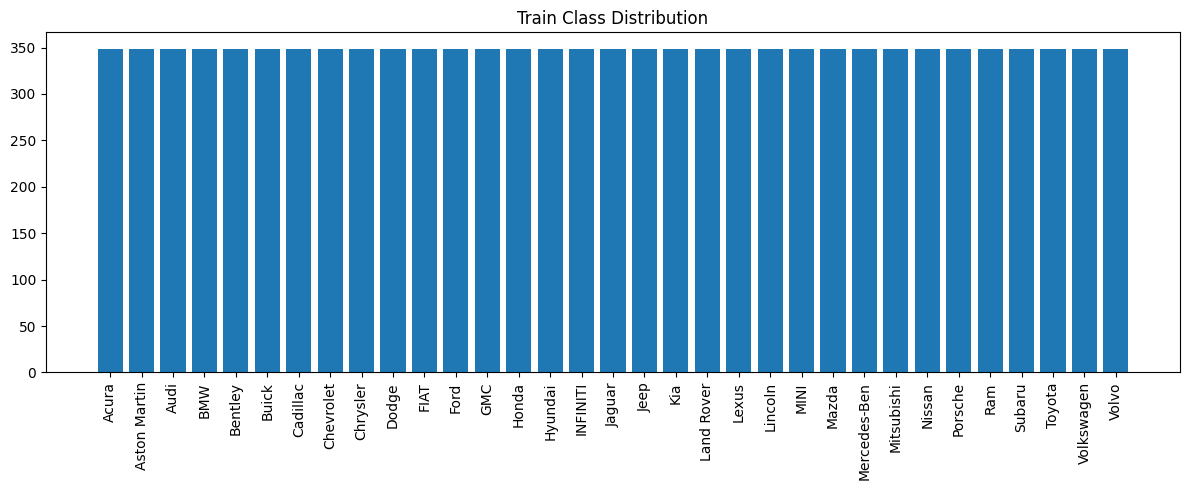

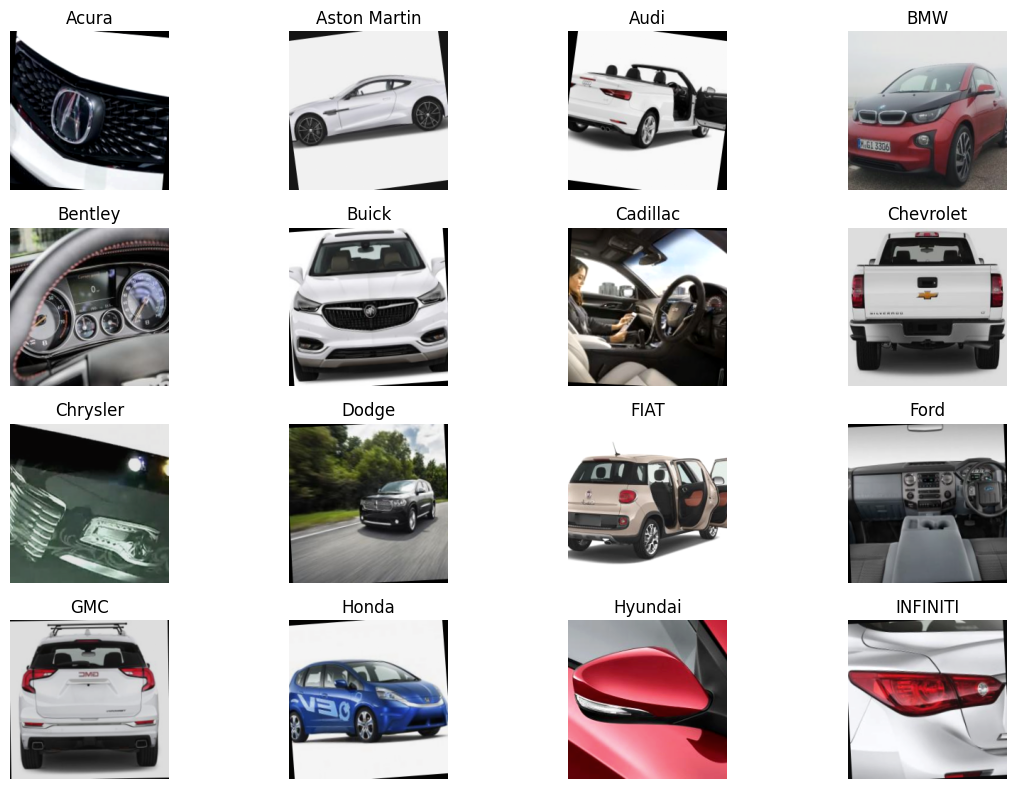

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]
2025-09-26 16:12:47.710186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758903167.940605      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758903168.007462      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 01 | LR 1.00e-03 | Train 3.3290/0.109 | Val 3.1094/0.159
Epoch 02 | LR 1.00e-03 | Train 2.9887/0.190 | Val 3.0110/0.184
Epoch 03 | LR 1.00e-03 | Train 2.8513/0.224 | Val 3.1417/0.188
Epoch 04 | LR 1.00e-03 | Train 2.7777/0.241 | Val 3.0342/0.198
Epoch 05 | LR 5.00e-04 | Train 2.7335/0.253 | Val 3.0173/0.207
Epoch 06 | LR 5.00e-04 | Train 2.5904/0.289 | Val 2.9228/0.225
Epoch 07 | LR 5.00e-04 | Train 2.5710/0.292 | Val 2.9126/0.240
Epoch 08 | LR 5.00e-04 | Train 2.5576/0.300 | Val 2.8887/0.235
Epoch 09 | LR 5.00e-04 | Train 2.5356/0.304 | Val 2.8923/0.238
Epoch 10 | LR 5.00e-04 | Train 2.5205/0.310 | Val 2.8936/0.239
Epoch 11 | LR 2.50e-04 | Train 2.5166/0.310 | Val 2.9291/0.229
Epoch 12 | LR 2.50e-04 | Train 2.4564/0.324 | Val 2.8664/0.246
Epoch 13 | LR 2.50e-04 | Train 2.4497/0.329 | Val 2.8637/0.240
Epoch 14 | LR 2.50e-04 | Train 2.4414/0.328 | Val 2.8738/0.245
Epoch 15 | LR 2.50e-04 | Train 2.4376/0.327 | Val 2.8699/0.242

Toplam eğitim süresi: 7.3 dk
En iyi model kaydedildi: 

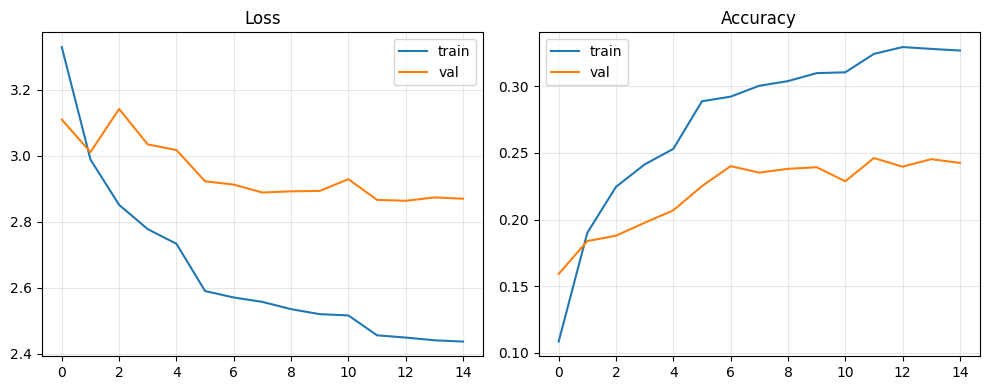


Classification Report (Test):

               precision    recall  f1-score   support

        Acura     0.2308    0.1600    0.1890        75
 Aston Martin     0.2875    0.6133    0.3915        75
         Audi     0.2326    0.4000    0.2941        75
          BMW     0.1667    0.1200    0.1395        75
      Bentley     0.2826    0.1733    0.2149        75
        Buick     0.1515    0.2000    0.1724        75
     Cadillac     0.2969    0.2533    0.2734        75
    Chevrolet     0.2424    0.1067    0.1481        75
     Chrysler     0.4545    0.4000    0.4255        75
        Dodge     0.2840    0.3067    0.2949        75
         FIAT     0.5172    0.4000    0.4511        75
         Ford     0.1091    0.0800    0.0923        75
          GMC     0.4565    0.2800    0.3471        75
        Honda     0.1707    0.0933    0.1207        75
      Hyundai     0.2203    0.1733    0.1940        75
     INFINITI     0.1739    0.4800    0.2553        75
       Jaguar     0.1818    0.10

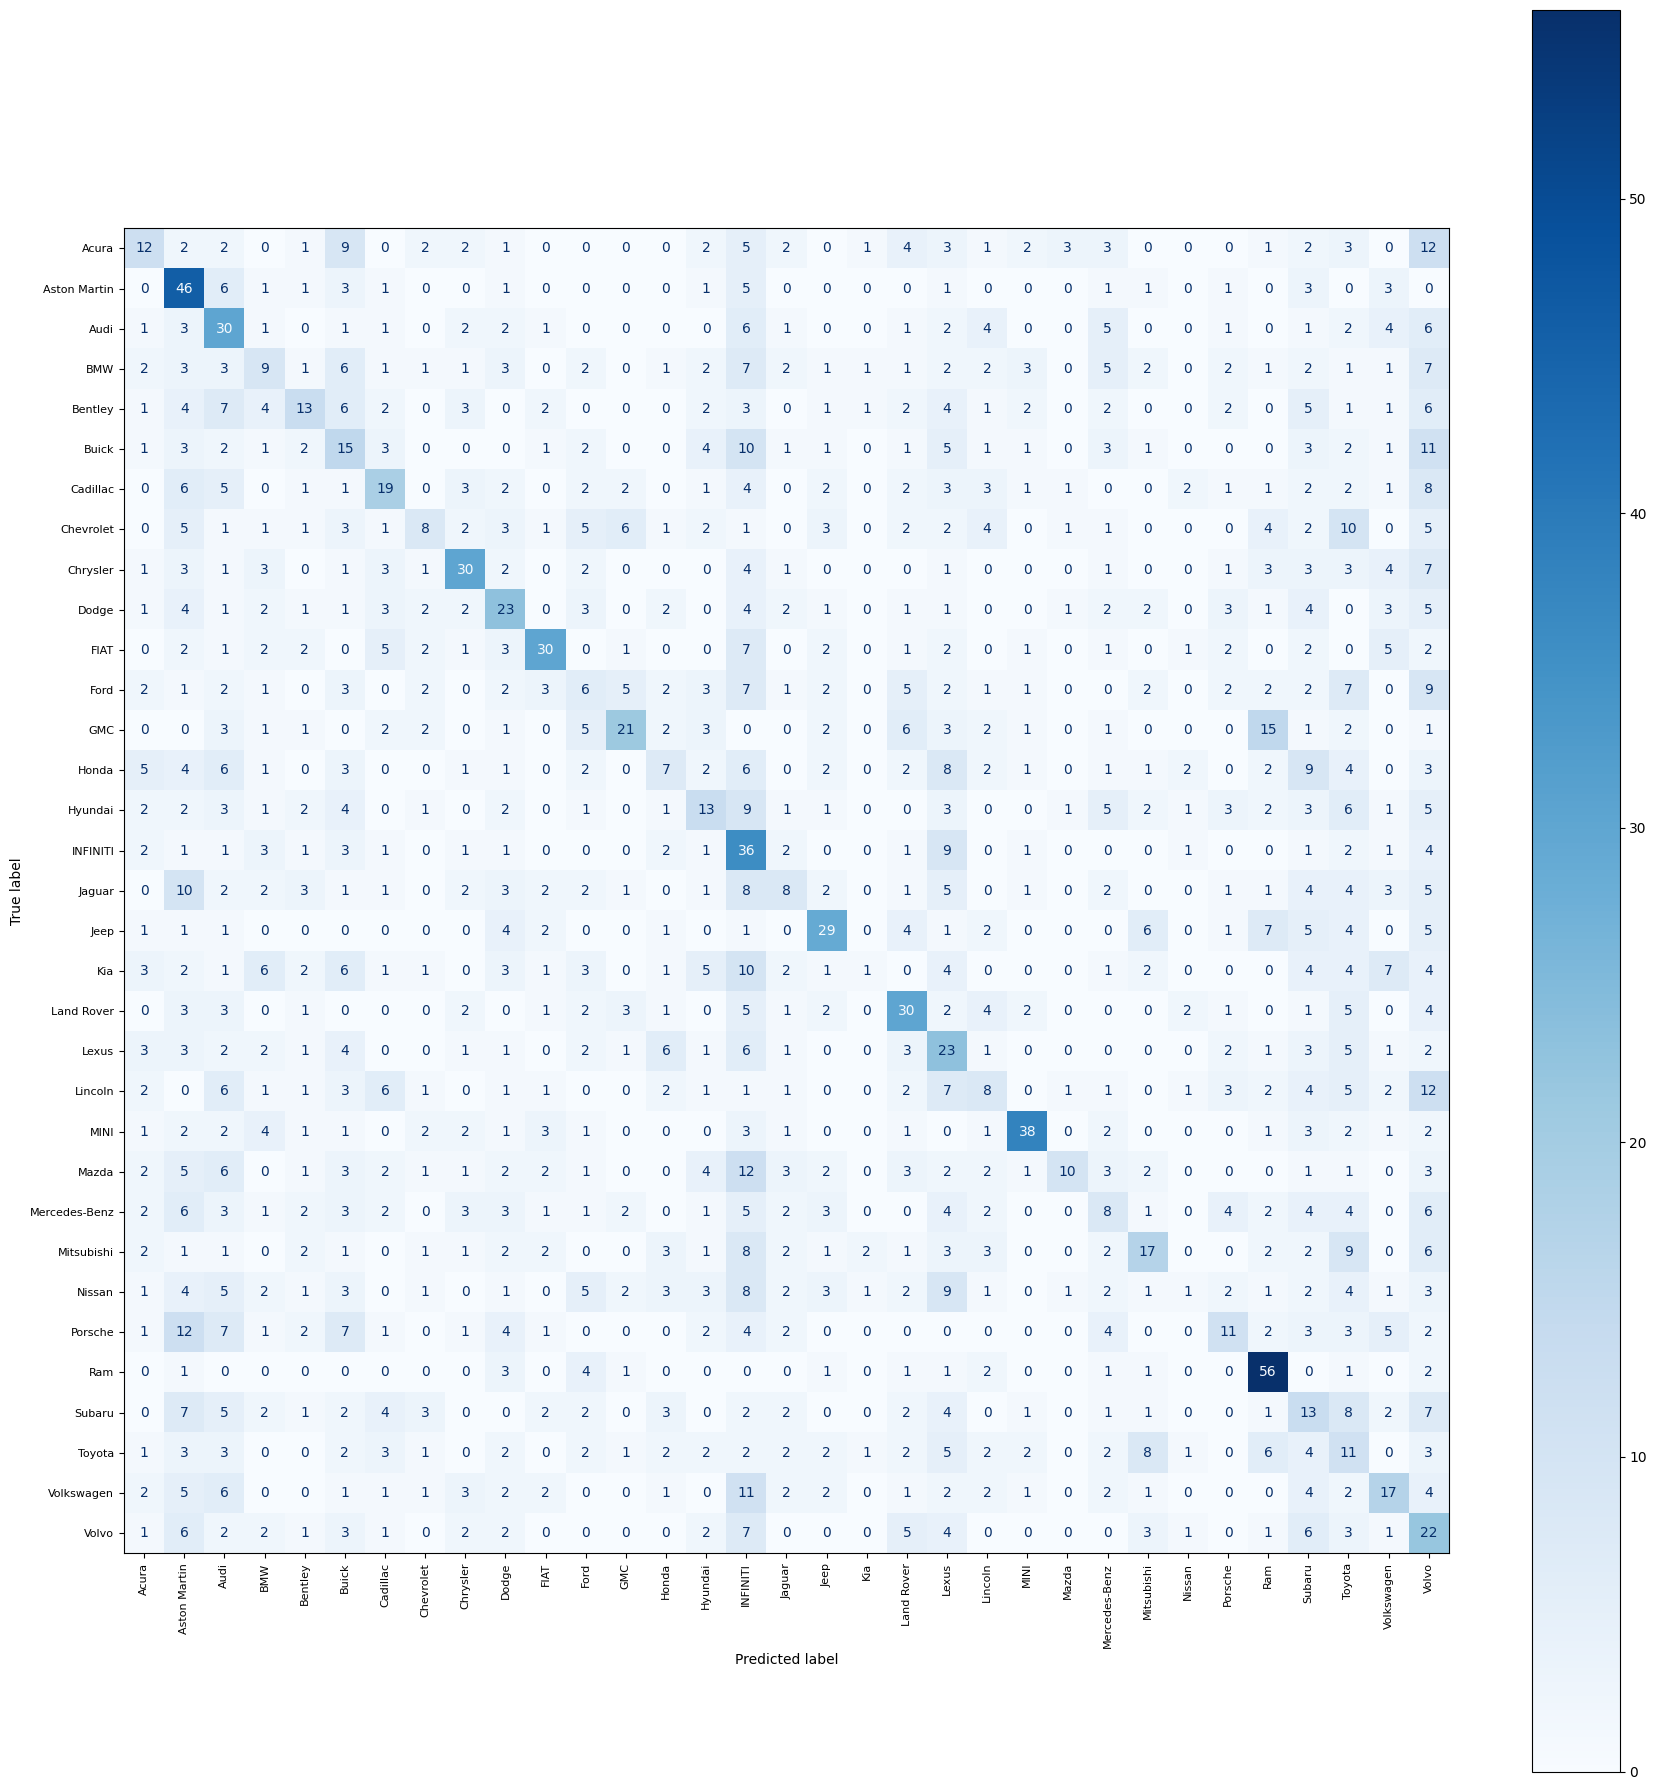

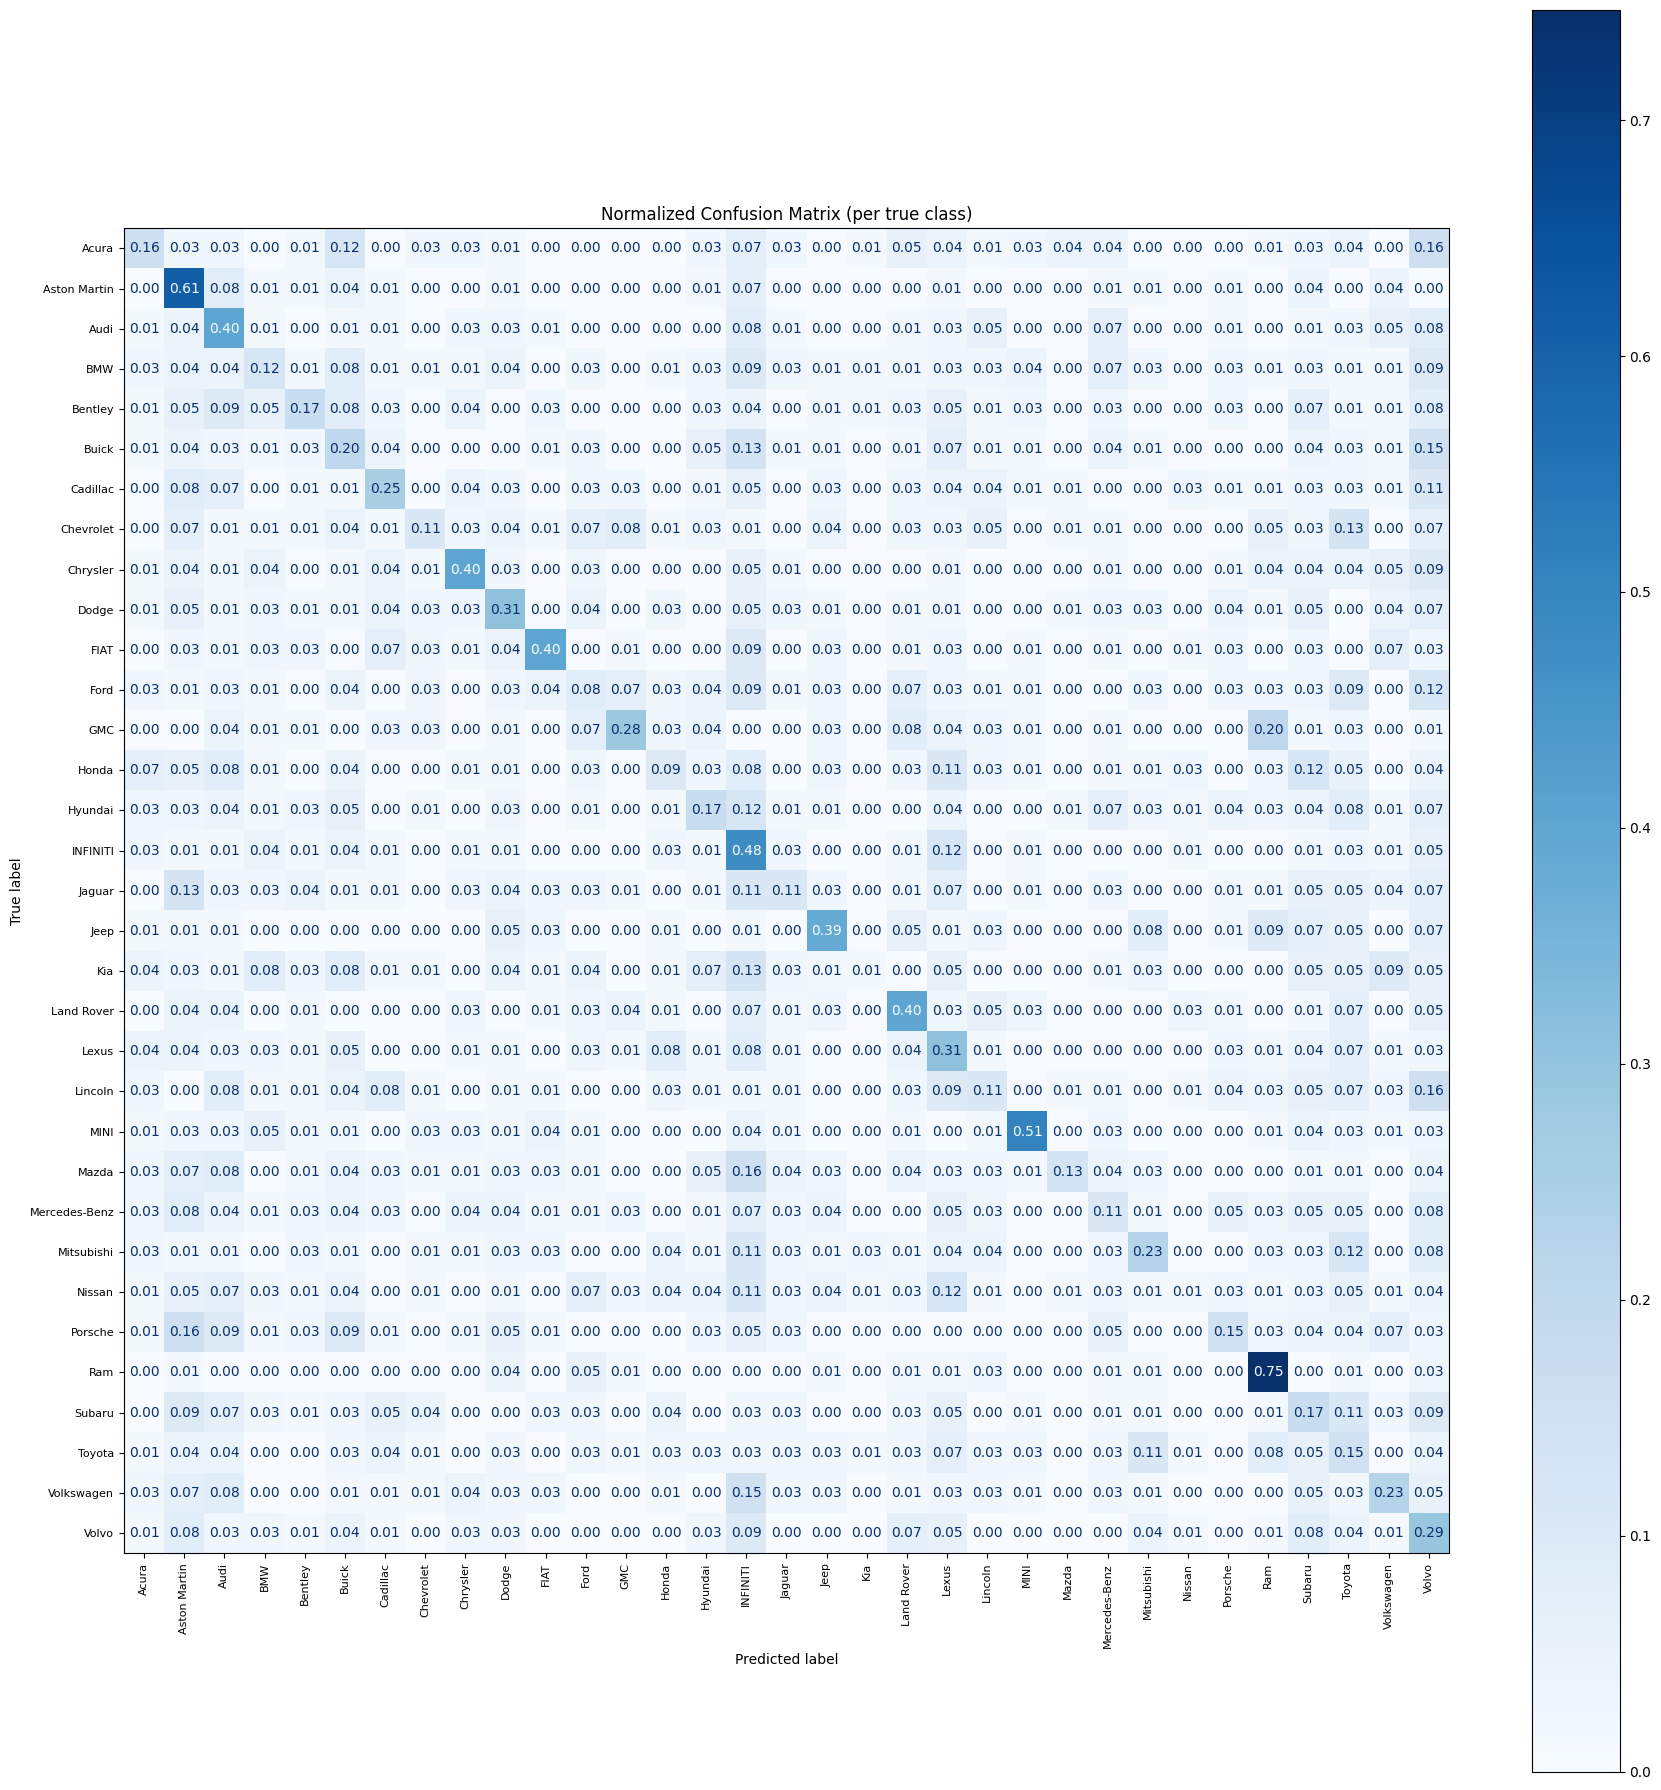

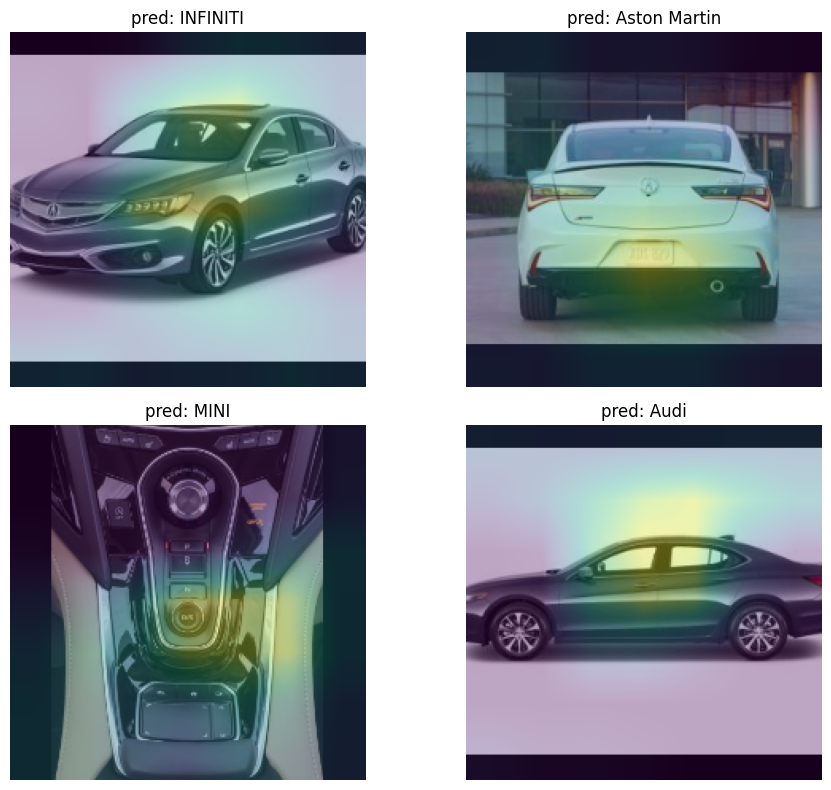

In [3]:

import numpy as np, torch, cv2, math, random, os
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
from pathlib import Path
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
ImageFile.LOAD_TRUNCATED_IMAGES = True

USE_TENSORBOARD = True         # izleme 
USE_EARLY_STOP  = True         # early stopping
USE_CLASS_WEIGHTS = False      # CrossEntropyLoss'ı class-weight ile kur
USE_WEIGHTED_SAMPLER = False   # train loader için WeightedRandomSampler
RUN_GRADCAM_DEMO = True        # eğitimden sonra birkaç görüntüde Grad-CAM
RUN_HP_SEARCH = False          # mini hiperparametre taraması fonksiyonunu çalıştır

DATA_DIR = Path("/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset")
TRAIN_DIR, VAL_DIR, TEST_DIR = DATA_DIR/"train", DATA_DIR/"val", DATA_DIR/"test"
IMG_SIZE, BATCH_SIZE, NUM_WORKERS, SEED = 224, 16, 2, 42   # bu kısımı değiştiriyorum
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp",".tiff",".jfif",".gif"}

try:
    mean_rgb, std_rgb = mean_rgb.tolist(), std_rgb.tolist()
except Exception:
    mean_rgb = [0.485, 0.456, 0.406]
    std_rgb  = [0.229, 0.224, 0.225]

def RRC(size, **kwargs):
    try:
        return A.RandomResizedCrop(size=(size, size), **kwargs)
    except TypeError:
        return A.RandomResizedCrop(height=size, width=size, **kwargs)

train_aug = A.Compose([
    RRC(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=8, p=0.6),
    A.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.12, hue=0.02, p=0.7),
    A.Normalize(mean=mean_rgb, std=std_rgb),
    ToTensorV2(),
])

valid_aug = A.Compose([
    A.LongestMaxSize(max_size=int(IMG_SIZE*1.15)),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=mean_rgb, std=std_rgb),
    ToTensorV2(),
])

class AlbumentationsImageFolder(Dataset):
    def __init__(self, root_dir: Path, transform):
        self.root = Path(root_dir)
        self.transform = transform
        self.samples, self.class_to_idx = [], {}
        classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        for c in classes:
            for p in (self.root / c).rglob("*"):
                if p.is_file() and p.suffix.lower() in IMG_EXTS:
                    self.samples.append((str(p), self.class_to_idx[c]))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        with Image.open(path) as im:
            img = np.asarray(im.convert("RGB"))
        img = self.transform(image=img)["image"]
        return img, label

torch.manual_seed(SEED)
if VAL_DIR.exists():
    train_base = AlbumentationsImageFolder(TRAIN_DIR, train_aug)
    val_base   = AlbumentationsImageFolder(VAL_DIR,   valid_aug)
    train_ds, val_ds = train_base, val_base
else:
    
    full_index_ds = AlbumentationsImageFolder(TRAIN_DIR, transform=None)  
    gen = torch.Generator().manual_seed(SEED)
    val_len  = max(1, int(0.15 * len(full_index_ds)))
    train_len = len(full_index_ds) - val_len
    perm = torch.randperm(len(full_index_ds), generator=gen)
    train_idx, val_idx = perm[:train_len], perm[train_len:]

    train_base = AlbumentationsImageFolder(TRAIN_DIR, transform=train_aug)
    val_base   = AlbumentationsImageFolder(TRAIN_DIR, transform=valid_aug)
    train_ds = Subset(train_base, train_idx.tolist())
    val_ds   = Subset(val_base,   val_idx.tolist())


base_ds = train_ds.dataset if hasattr(train_ds, "dataset") else train_ds
idx_to_class = {v:k for k,v in base_ds.class_to_idx.items()}
class_to_idx = base_ds.class_to_idx
NUM_CLASSES = len(idx_to_class)

from collections import Counter
def class_counts(ds):
    if isinstance(ds, Subset):
        base, idxs = ds.dataset, ds.indices
        labels = [ base[i][1] for i in idxs ]
    else:
        labels = [ ds[i][1] for i in range(len(ds)) ]
    cnt = Counter(int(y) for y in labels)
    names = [idx_to_class[i] for i in range(NUM_CLASSES)]
    vals = [cnt.get(i,0) for i in range(NUM_CLASSES)]
    return names, vals

names, vals = class_counts(train_ds)
plt.figure(figsize=(12,5))
plt.bar(range(len(names)), vals)
plt.xticks(range(len(names)), [n[:12] for n in names], rotation=90)
plt.title("Train Class Distribution"); plt.tight_layout(); plt.show()

# ---- Class imbalance opsiyonları ----
train_sampler = None
if USE_WEIGHTED_SAMPLER:
    counts = np.array(vals, dtype=np.float32)
    counts[counts==0] = 1.0
    inv = 1.0 / counts
    if isinstance(train_ds, Subset):
        weights = [inv[train_ds.dataset[i][1]] for i in train_ds.indices]
    else:
        weights = [inv[train_ds[i][1]] for i in range(len(train_ds))]
    train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

# ---- DataLoader'lar ----
test_ds = AlbumentationsImageFolder(TEST_DIR, valid_aug) if TEST_DIR.exists() else None
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=(train_sampler is None),
                          sampler=train_sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True) if test_ds else None

# ---- Sınıf-dengeli augment grid (tek sınıfa abanmayı önler) ----
def balanced_grid_sample(ds, per_class=1, max_total=16):
    if isinstance(ds, Subset):
        base, idxs = ds.dataset, ds.indices
        pool = [(i, base[i][1]) for i in idxs]
    else:
        pool = [(i, ds[i][1]) for i in range(len(ds))]
    by_class = {}
    for i, y in pool:
        by_class.setdefault(int(y), []).append(i)
    chosen = []
    for c in range(NUM_CLASSES):
        if c in by_class:
            random.shuffle(by_class[c])
            chosen += by_class[c][:per_class]
        if len(chosen) >= max_total: break
    return chosen[:max_total]

sel = balanced_grid_sample(train_ds, per_class=1, max_total=16)
imgs, labels = [], []
for i in sel:
    x, y = (train_ds.dataset[i] if isinstance(train_ds, Subset) else train_ds[i])
    imgs.append(x); labels.append(y)
imgs = torch.stack(imgs); labels = torch.tensor(labels)
m = torch.tensor(mean_rgb).view(1,3,1,1)
s = torch.tensor(std_rgb).view(1,3,1,1)
x = torch.clamp(imgs*s + m, 0, 1)
plt.figure(figsize=(12,8))
for i in range(len(sel)):
    plt.subplot(4,4,i+1)
    plt.imshow(x[i].permute(1,2,0).cpu().numpy())
    plt.title(idx_to_class[int(labels[i])][:18])
    plt.axis("off")
plt.tight_layout(); plt.show()

import time, torch.nn as nn, torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.amp import GradScaler, autocast

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 15
LR = 1e-3
USE_TL = True
SAVE_PATH = "best_model.pt"

# ---- Model ----
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.feat = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128),
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.cls  = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.feat(x); x = self.pool(x); x = self.cls(x); return x

if USE_TL:
    import torchvision.models as tvm
    model = tvm.resnet18(weights=tvm.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    for name, p in model.named_parameters():
        if not name.startswith("fc"):
            p.requires_grad = False
    params = [p for p in model.parameters() if p.requires_grad]
else:
    model = SimpleCNN(NUM_CLASSES)
    params = model.parameters()

model = model.to(DEVICE)

# ---- Class-weighted loss opsiyonu ----
if USE_CLASS_WEIGHTS:
    # train dağılımından ağırlık çıkar
    counts = np.array(vals, dtype=np.float32); counts[counts==0] = 1.0
    class_w = torch.tensor((counts.sum()/counts), dtype=torch.float32, device=DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_w)
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(params, lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

# ---- TensorBoard (opsiyonel) ----
if USE_TENSORBOARD:
    try:
        from torch.utils.tensorboard import SummaryWriter
        writer = SummaryWriter(log_dir="runs/carbrand")
    except Exception as e:
        print("TensorBoard açılamadı:", e)
        USE_TENSORBOARD = False

def run_epoch(loader, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    torch.set_grad_enabled(train)
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = torch.as_tensor(yb, device=DEVICE)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits = model(xb)
            loss = criterion(logits, yb)
        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        loss_sum += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    torch.set_grad_enabled(True)
    return loss_sum/total, correct/total

# ---- Early Stopping ----
best_val = float("inf")
best_epoch = 0
PATIENCE = 5  
hist = {"tr_loss":[], "tr_acc":[], "va_loss":[], "va_acc":[]}
t0 = time.time()

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    with torch.no_grad():
        va_loss, va_acc = run_epoch(val_loader, train=False)
    scheduler.step(va_loss)

    hist["tr_loss"].append(tr_loss); hist["tr_acc"].append(tr_acc)
    hist["va_loss"].append(va_loss); hist["va_acc"].append(va_acc)

    if USE_TENSORBOARD:
        writer.add_scalar("Loss/train", tr_loss, epoch)
        writer.add_scalar("Loss/val",   va_loss, epoch)
        writer.add_scalar("Acc/train",  tr_acc,  epoch)
        writer.add_scalar("Acc/val",    va_acc,  epoch)

    cur_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d} | LR {cur_lr:.2e} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")

    if va_loss < best_val:
        best_val = va_loss
        best_epoch = epoch
        torch.save({
            "model": model.state_dict(),
            "num_classes": NUM_CLASSES,
            "idx_to_class": idx_to_class
        }, SAVE_PATH)

    if USE_EARLY_STOP and (epoch - best_epoch) >= PATIENCE:
        print(f"Early stop: {epoch} (best val @ {best_epoch}, loss={best_val:.4f})")
        break

if USE_TENSORBOARD:
    writer.close()

print(f"\nToplam eğitim süresi: {(time.time()-t0)/60:.1f} dk")
print(f"En iyi model kaydedildi: {SAVE_PATH}")

# ---- Eğitim grafikleri ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist["tr_loss"], label="train"); plt.plot(hist["va_loss"], label="val"); plt.title("Loss"); plt.legend(); plt.grid(True, alpha=0.3)
plt.subplot(1,2,2); plt.plot(hist["tr_acc"], label="train"); plt.plot(hist["va_acc"], label="val"); plt.title("Accuracy"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

def quick_hparam_sweep(configs, max_epochs=3):
    results = []
    base_state = model.state_dict()
    for i, cfg in enumerate(configs, 1):
        print(f"\n[HP-{i}/{len(configs)}] cfg={cfg}")
        model.load_state_dict(base_state, strict=False)
        # sadece FC katmanı eğitilecekse params yeter, yoksa tümü
        opt = optim.Adam([p for p in model.parameters() if p.requires_grad],
                         lr=cfg.get("lr", LR), weight_decay=cfg.get("wd", 0.0))
        sch = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=1)
        best_local = float("inf")
        for ep in range(1, max_epochs+1):
            tr_l, tr_a = run_epoch(train_loader, True)
            with torch.no_grad():
                va_l, va_a = run_epoch(val_loader, False)
            sch.step(va_l)
            print(f"  ep{ep:02d}  Train {tr_l:.4f}/{tr_a:.3f}  Val {va_l:.4f}/{va_a:.3f}")
            best_local = min(best_local, va_l)
        results.append({**cfg, "best_val_loss": best_local})
    return results

if RUN_HP_SEARCH:
    sweep_cfg = [{"lr":1e-3,"wd":0.0},{"lr":5e-4,"wd":1e-4},{"lr":1e-4,"wd":1e-4}]
    hp_res = quick_hparam_sweep(sweep_cfg, max_epochs=3)
    print("\nHP Sweep Results:", hp_res)

# ---- Test değerlendirme ----
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

state = torch.load(SAVE_PATH, map_location=DEVICE)
model.load_state_dict(state["model"], strict=False)
model.eval()

_saved = state.get("idx_to_class", idx_to_class)
if isinstance(_saved, dict):
    num_classes_ckpt = max(_saved.keys()) + 1
    idx_to_class_ckpt = [ _saved.get(i, f"class_{i}") for i in range(num_classes_ckpt) ]
else:
    idx_to_class_ckpt = list(_saved)
    num_classes_ckpt = len(idx_to_class_ckpt)

labels = list(range(num_classes_ckpt))
target_names = [idx_to_class_ckpt[i] for i in labels]

if test_loader is not None:
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE, non_blocking=True)
            logits = model(xb)
            y_pred.extend(logits.argmax(1).cpu().tolist())
            y_true.extend(yb.cpu().tolist())

    print("\nClassification Report (Test):\n")
    print(classification_report(
        y_true, y_pred, labels=labels, target_names=target_names,
        digits=4, zero_division=0
    ))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(18, 18))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format="d", colorbar=True)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    plt.tight_layout(); plt.show()

    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    fig, ax = plt.subplots(figsize=(18, 18))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format=".2f", colorbar=True)
    ax.set_title("Normalized Confusion Matrix (per true class)")
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    plt.tight_layout(); plt.show()
else:
    print("Test set bulunamadı; yalnızca train/val raporlandı.")


    # ---- Grad-CAM (doküman gereksinimi) ----
if RUN_GRADCAM_DEMO and USE_TL:
    model.eval()

    # (1) Sadece Grad-CAM için: gradyan akışını aç (eğitim değil, görselleştirme)
    for p in model.parameters():
        p.requires_grad_(True)

    target_layer = model.layer4[-1].conv2
    grads, acts = [], []

    def fwd_hook(_, __, output):
        # output requires_grad=True olacak (aşağıda input'u da işaretliyoruz)
        acts.append(output)

    def bwd_hook(_, grad_input, grad_output):
        grads.append(grad_output[0])

    h1 = target_layer.register_forward_hook(fwd_hook)
    # PyTorch sürüm uyumluluğu: full_backward_hook varsa onu, yoksa backward_hook
    try:
        h2 = target_layer.register_full_backward_hook(bwd_hook)
    except AttributeError:
        h2 = target_layer.register_backward_hook(bwd_hook)

    def gradcam(input_tensor, class_idx=None):
        grads.clear(); acts.clear()
        model.zero_grad(set_to_none=True)
        input_tensor = input_tensor.detach().clone().requires_grad_(True)

        logits = model(input_tensor)
        if class_idx is None:
            
            sel = logits.argmax(1)
        else:
            sel = class_idx.to(logits.device)

        loss = logits[torch.arange(logits.size(0), device=logits.device), sel]
        loss.sum().backward()

        # Güvenlik: hook’lar çalıştı mı?
        if not acts or not grads:
            raise RuntimeError("Grad-CAM: Hook'lar tetiklenmedi; requires_grad zincirini kontrol et.")

        A = acts[-1]      # [B,C,H,W]
        G = grads[-1]     # [B,C,H,W]
        w = G.mean(dim=(2,3), keepdim=True)           # [B,C,1,1]
        cam = (w * A).sum(dim=1, keepdim=True)        # [B,1,H,W]
        cam = torch.relu(cam)
        cam_min = cam.amin(dim=(2,3), keepdim=True)
        cam_max = cam.amax(dim=(2,3), keepdim=True)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-6)
        return cam

    # Val setten 4 örnek üzerinde göster
    xb, yb = next(iter(val_loader))
    xb = xb[:4].to(DEVICE)

    with torch.no_grad():
        preds = model(xb).argmax(1)

    cam = gradcam(xb)  # <-- artık grads dolu olacak

    m = torch.tensor(mean_rgb, device=DEVICE).view(1,3,1,1)
    s = torch.tensor(std_rgb,  device=DEVICE).view(1,3,1,1)

    import cv2
    plt.figure(figsize=(10,8))
    for i in range(xb.size(0)):
        img = (xb[i].unsqueeze(0)*s + m).squeeze().permute(1,2,0).clamp(0,1).detach().cpu().numpy()
        heat = cv2.resize(cam[i,0].detach().cpu().numpy(), (img.shape[1], img.shape[0]))
        plt.subplot(2,2,i+1)
        plt.imshow(img)
        plt.imshow(heat, alpha=0.35)
        plt.title(f"pred: {idx_to_class[int(preds[i].item())]}")
        plt.axis("off")
    plt.tight_layout(); plt.show()

    h1.remove(); h2.remove()


Sonuç olarak accuracy konusunda çok bir oynama olmadı.Eğitim süresi konusunda 16 batch size a sahip olan daha kısa sürede eğitildi.